In [1]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn import model_selection

# V4 (already removed low var) Analysis

In [43]:
all_data = pd.read_pickle('database/plasticizer_data_all.pkl')
rdkit = pd.read_excel('database/plasticizer_data_v4(rdkit_high_var).xls')

In [44]:
rdkit = rdkit[rdkit.columns[1:]]

In [45]:
all_data = all_data[all_data.columns[-18:]]

In [46]:
data = pd.concat([rdkit, all_data], axis=1)

In [47]:
variances = []
for col in data.columns[5:]:
    vals = np.array(data[col], dtype='float64').reshape(-1,1)
    vals = vals[~np.isnan(vals)].reshape(-1,1)
    scaler = MinMaxScaler()
    scaler.fit(vals)
    if pd.isnull(np.std(scaler.transform(vals))**2):
        variances.append(0)
    else:
        variances.append(np.std(scaler.transform(vals))**2)

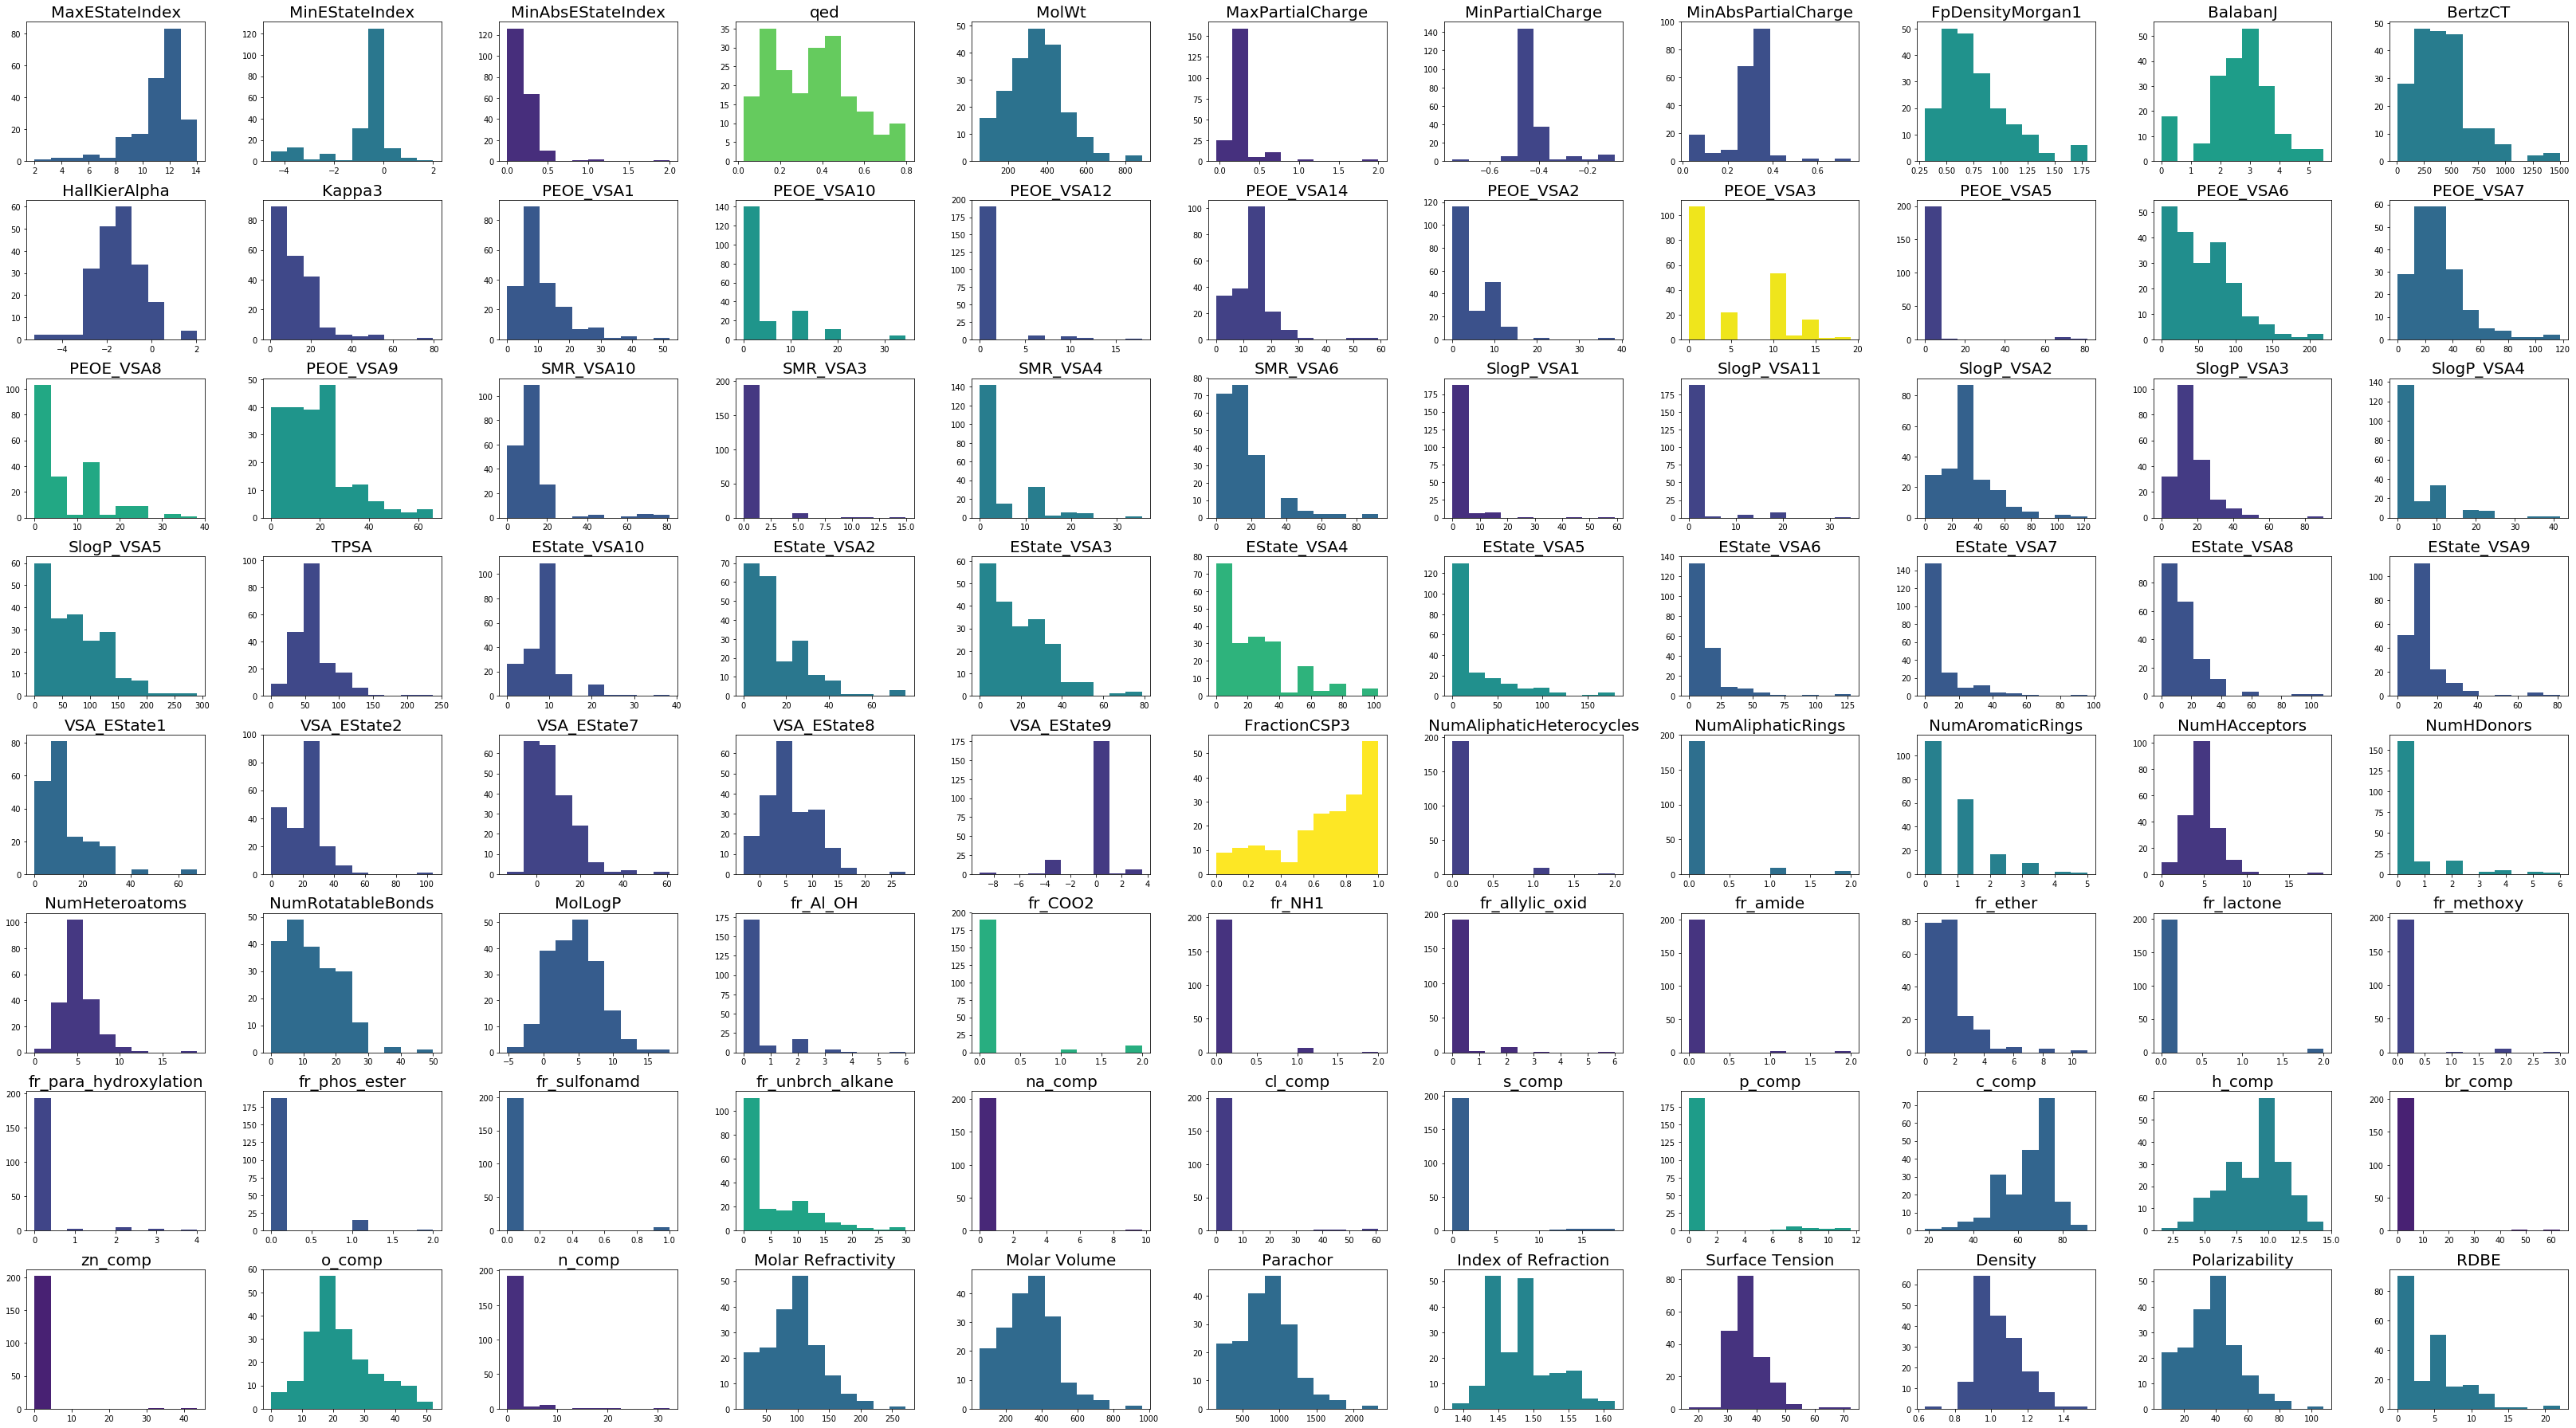

In [53]:
fig, ax = plt.subplots(8,11,figsize=(45,25))
cmap = cm.get_cmap('viridis')
max_var = max(variances)

for i, ax in enumerate(fig.axes):
    ax.hist(data[data.columns[i+5]].to_numpy().astype('float64'), color=cmap(variances[i] / max_var))
    ax.set_title(data.columns[i+5], fontsize=20)
fig.tight_layout()
plt.show()

In [54]:
used_for_pvc = []
for val in data['Used for Polymeric Materials'].values:
    if pd.isnull(val):
        used_for_pvc.append(np.nan)
    elif 'PVC' in val:
        used_for_pvc.append(1)
    else:
        used_for_pvc.append(0)

data['Used for PVC'] = pd.Series(used_for_pvc)

## Predicting PVC Use

### Logistic Regression

In [119]:
clean_data = data[data.columns[5:]].dropna(axis=0)
for col in clean_data.columns[:-1]:
    scaler = MinMaxScaler()
    vals = clean_data[col].to_numpy().astype('float64')
    vals = scaler.fit_transform(vals.reshape(-1,1))
    clean_data[col] = vals
X = clean_data[clean_data.columns[:-1]].to_numpy()
y = clean_data['Used for PVC'].to_numpy()

clf = LogisticRegression(solver='liblinear').fit(X, y)
print('Training accuracy - {}'.format(clf.score(X, y)))

Training accuracy - 0.852112676056338


In [120]:
accs = []

loo = model_selection.LeaveOneOut()
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf = LogisticRegression(solver='liblinear', max_iter=100).fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    accs.append(acc)

print('Test accuracy (LOO) - {}'.format(np.mean(accs)))

Test accuracy (LOO) - 0.823943661971831


In [121]:
feature_importance=pd.DataFrame(np.hstack((np.array(clean_data.columns[:-1]).T.reshape(-1,1), clf.coef_.T)), columns=['feature', 'importance'])
feature_importance['importance']=pd.to_numeric(feature_importance['importance'])

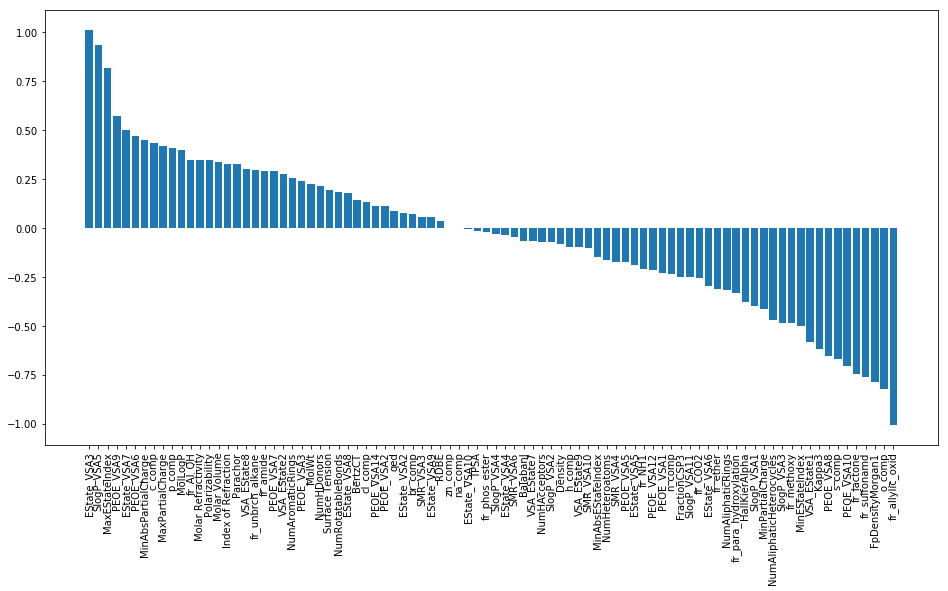

In [122]:
fig = plt.figure(figsize=(16,8))

plt.bar(range(len(feature_importance['importance'])), feature_importance.sort_values(by='importance', ascending=False)['importance'])
plt.xticks(range(len(feature_importance['importance'])), feature_importance.sort_values(by='importance', ascending=False)['feature'], rotation='vertical')
plt.show()

## Determining All Types of Polymers

In [130]:
all_polymers = []
for vals in data['Used for Polymeric Materials']:
    if pd.isnull(vals):
        continue
    vals = vals.split(',')
    for val in vals:
        all_polymers.append(val.strip())
all_polymers = list(set(all_polymers))
used_for_polymers = {}
for polymer in all_polymers:
    used_for_polymers[polymer] = []

for val in data['Used for Polymeric Materials']:
    for polymer in all_polymers:
        if pd.isnull(val):
            used_for_polymers[polymer].append(np.nan)
        elif polymer in val:
            used_for_polymers[polymer].append(1)
        else:
            used_for_polymers[polymer].append(0)

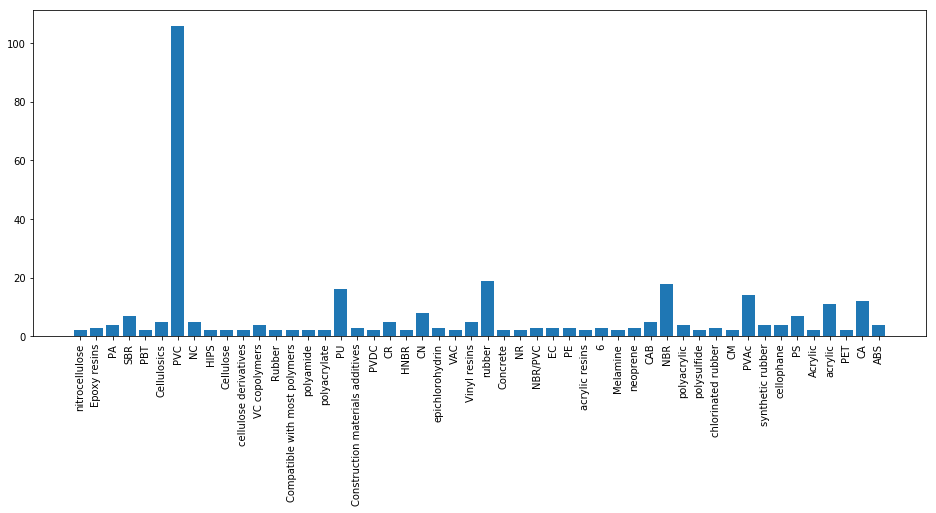

In [136]:
used_for_polymers = pd.DataFrame(used_for_polymers)
polymers = []
counts = []

for col in used_for_polymers.columns:
    count = used_for_polymers[col].sum()
    if count >= 2:
        polymers.append(col)
        counts.append(count)

fig = plt.figure(figsize=(16,6))
plt.bar(range(len(counts)), counts)
plt.xticks(range(len(counts)), polymers, rotation='vertical')
plt.show()

# V4 (rdkit) Analysis (Removing Low Variance Features)

In [2]:
data = pd.read_excel('database/plasticizer_data_v4(rdkit).xls')

In [3]:
cols = ['Plasticizer name', 'SMILES', 'CAS Registry No.', 'Chemical Category', 'Used for Polymeric Materials'] + list(data.columns[-200:])
data = data[cols]

In [4]:
variances = []
for col in data.columns[5:]:
    vals = np.array(data[col]).reshape(-1,1).astype('float64')
    scaler = MinMaxScaler()
    scaler.fit(vals)
    variances.append(np.std(scaler.transform(vals))**2)

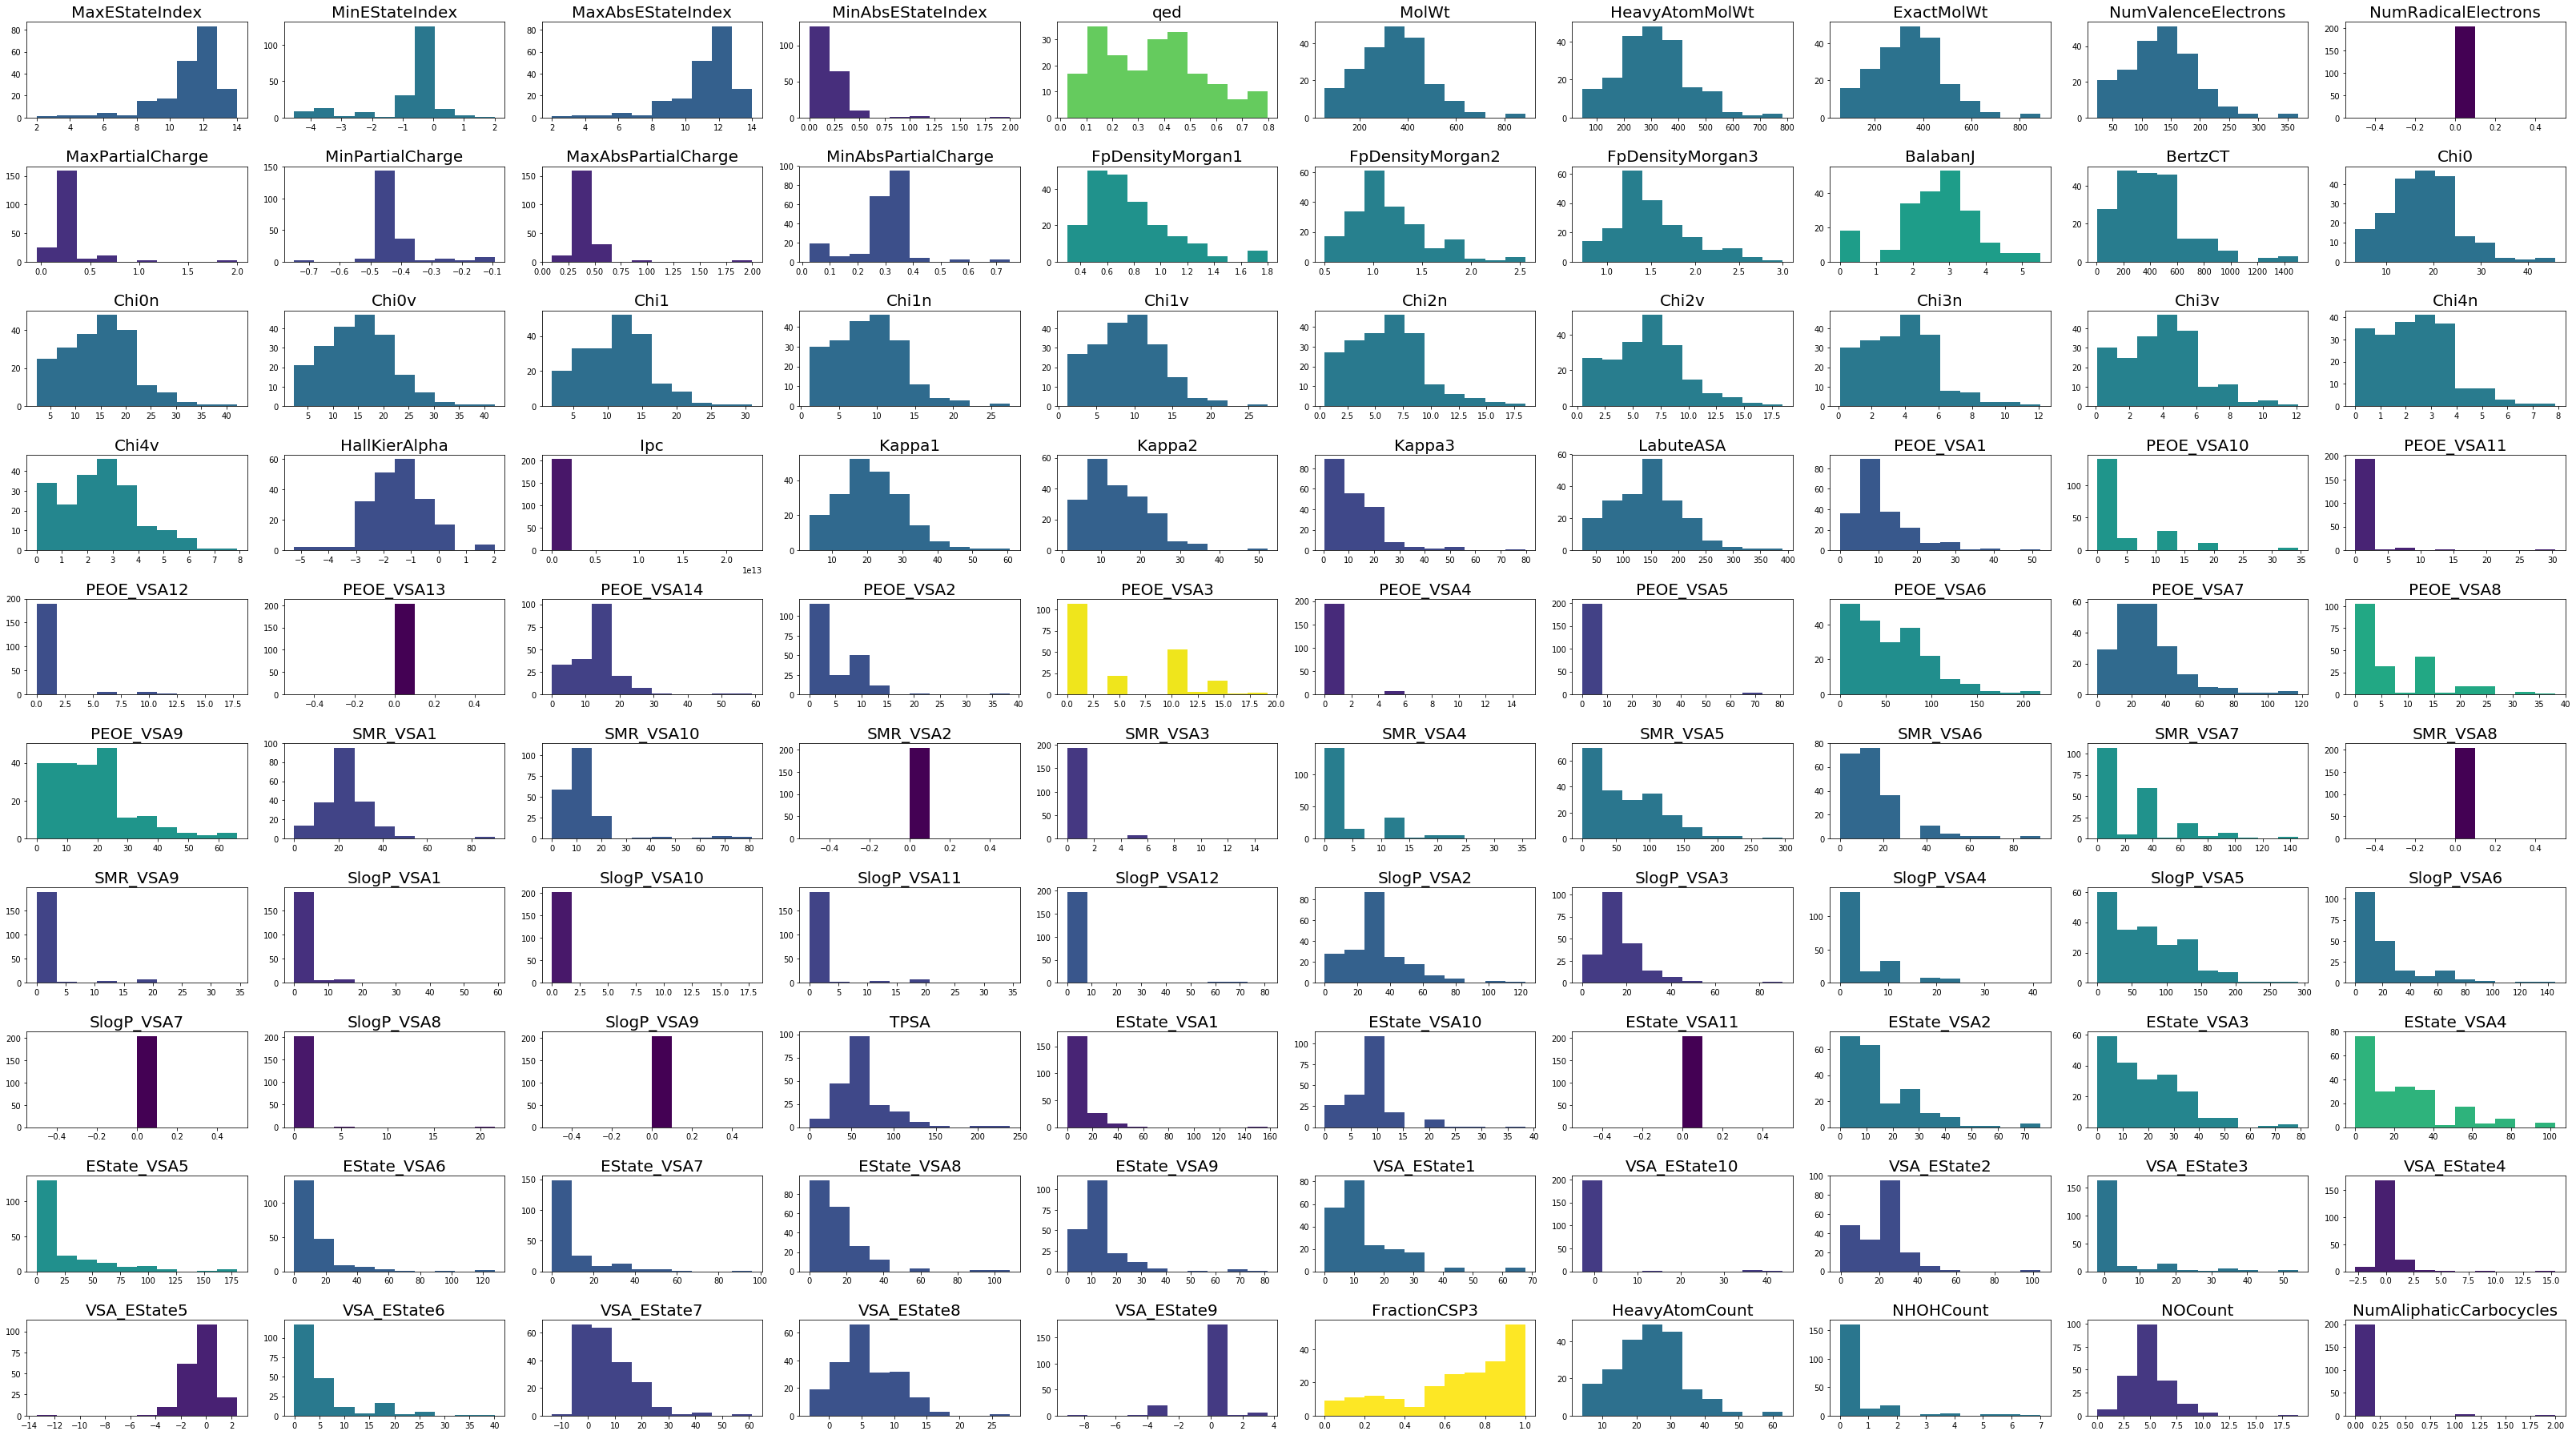

In [5]:
fig, ax = plt.subplots(10,10,figsize=(45,25))
cmap = cm.get_cmap('viridis')
max_var = max(variances)

for i, ax in enumerate(fig.axes):
    ax.hist(data[data.columns[i+5]], color=cmap(variances[i] / max_var))
    ax.set_title(data.columns[i+5], fontsize=20)
fig.tight_layout()
plt.show()

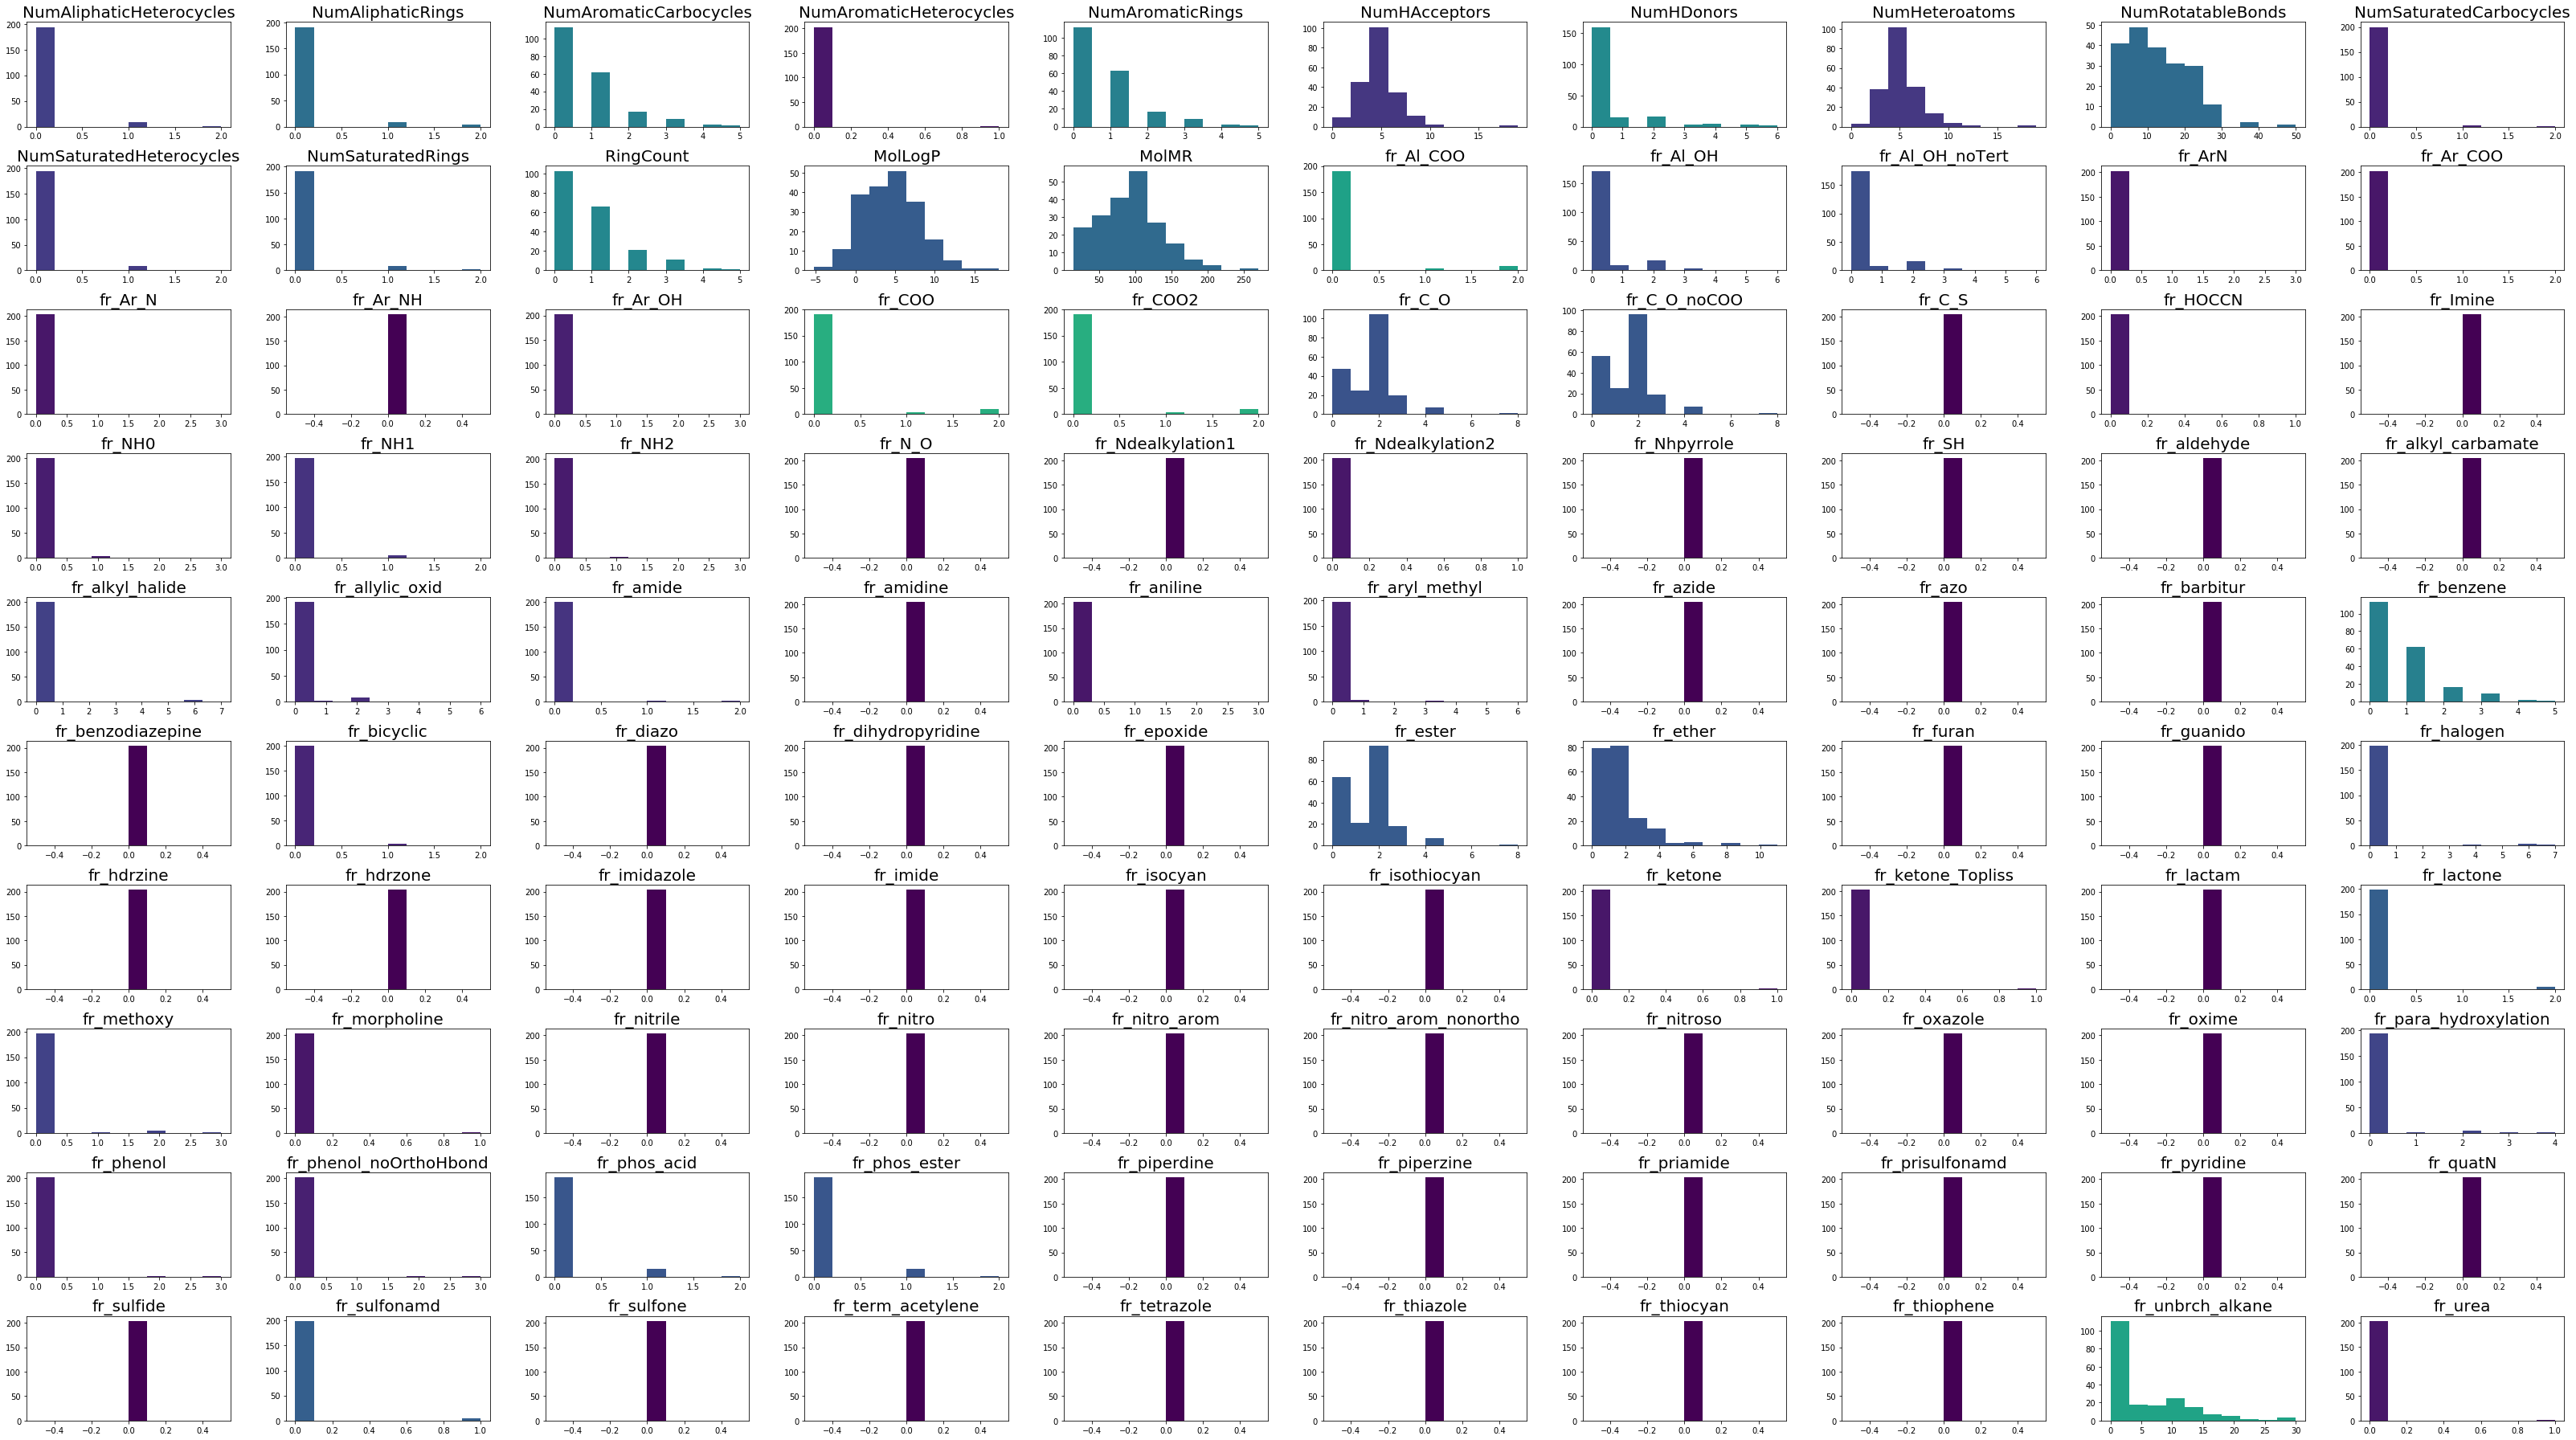

In [6]:
fig, ax = plt.subplots(10,10,figsize=(45,25))
cmap = cm.get_cmap('viridis')
max_var = max(variances)

for i, ax in enumerate(fig.axes):
    ax.hist(data[data.columns[i+105]], color=cmap(variances[i+100] / max_var))
    ax.set_title(data.columns[i+105], fontsize=20)
fig.tight_layout()
plt.show()

In [7]:
pop_idxs = []
pop_vars = variances.copy()
pop_cols = data.columns[5:].to_list()
for i, var in enumerate(variances):
    if var <= 1e-3:
        pop_idxs.append(i)
for idx in reversed(pop_idxs):
    pop_vars.pop(idx)
    pop_cols.pop(idx)
len(pop_cols)

147

In [8]:
cols = data.columns[:5].to_list() + pop_cols
len(cols)

152

In [9]:
data = data[cols]

In [10]:
corrs = np.zeros((len(pop_cols), len(pop_cols)))
for i in range(len(pop_cols)):
    data1 = data[pop_cols[i]]
    for j in range(len(pop_cols)):
        data2 = data[pop_cols[j]]
        coeff = abs(np.corrcoef(data1, data2)[0][1])
        corrs[i,j] = coeff

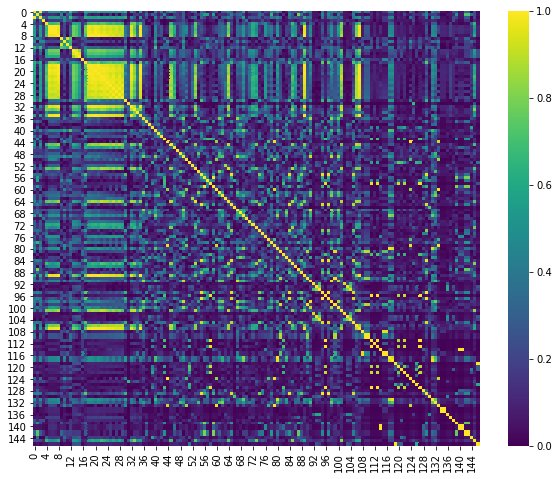

In [11]:
plt.figure(figsize=(10,8))
sns.heatmap(corrs, cmap='viridis')
plt.show()

In [12]:
rem_cols = ['MaxAbsEStateIndex', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'FpDensityMorgan2', 'FpDensityMorgan3', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'Kappa1', 'LabuteASA', 'HeavyAtomCount', 'MolMR', 'VSA_EState10', 'SMR_VSA1', 'SMR_VSA5', 'SMR_VSA7', 'SMR_VSA9', 'SlogP_VSA10', 'SlogP_VSA12', 'SlogP_VSA6']
pop_cols = list(set(pop_cols) - set(rem_cols))
data = data.drop(columns=rem_cols)

In [13]:
corrs = np.zeros((len(pop_cols), len(pop_cols)))
for i in range(len(pop_cols)):
    data1 = data[pop_cols[i]]
    for j in range(len(pop_cols)):
        data2 = data[pop_cols[j]]
        coeff = abs(np.corrcoef(data1, data2)[0][1])
        corrs[i,j] = coeff

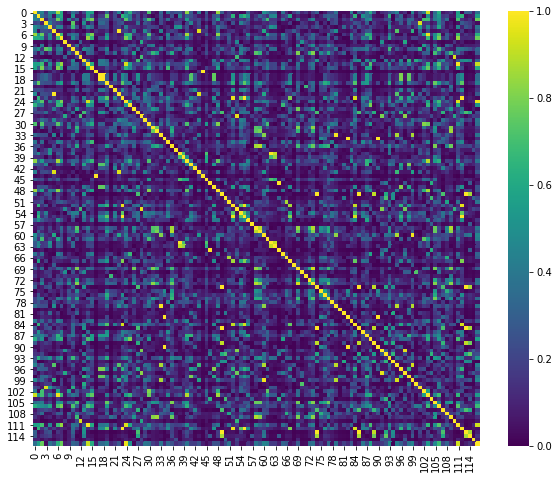

In [14]:
plt.figure(figsize=(10,8))
sns.heatmap(corrs, cmap='viridis')
plt.show()

In [15]:
rem_cols = ['fr_phenol_noOrthoHbond', 'fr_Ar_OH', 'fr_ketone_Topliss', 'NOCount', 'fr_benzene', 'fr_ArN', 'fr_Ar_N', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'fr_alkyl_halide', 'fr_HOCCN', 'fr_C_O', 'fr_C_O_noCOO', 'NHOHCount', 'fr_phos_acid', 'VSA_EState6', 'NumAromaticCarbocycles', 'fr_Al_COO', 'fr_COO', 'fr_Al_OH_noTert']
pop_cols = list(set(pop_cols) - set(rem_cols))
data = data.drop(columns=rem_cols)

In [16]:
corrs = np.zeros((len(pop_cols), len(pop_cols)))
for i in range(len(pop_cols)):
    data1 = data[pop_cols[i]]
    for j in range(len(pop_cols)):
        data2 = data[pop_cols[j]]
        coeff = abs(np.corrcoef(data1, data2)[0][1])
        corrs[i,j] = coeff

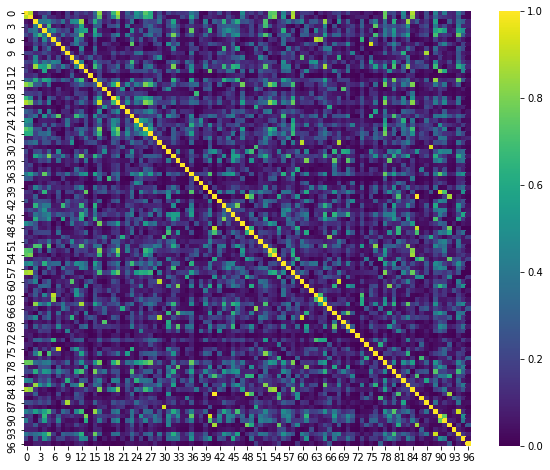

In [17]:
plt.figure(figsize=(10,8))
sns.heatmap(corrs, cmap='viridis')
plt.show()

In [18]:
rem_cols = ['fr_aniline', 'Kappa2', 'NumSaturatedCarbocycles', 'MaxAbsPartialCharge', 'fr_halogen', 'fr_NH2', 'VSA_EState3', 'RingCount', 'fr_ester']
pop_cols = list(set(pop_cols) - set(rem_cols))
data = data.drop(columns=rem_cols)

In [19]:
corrs = np.zeros((len(pop_cols), len(pop_cols)))
for i in range(len(pop_cols)):
    data1 = data[pop_cols[i]]
    for j in range(len(pop_cols)):
        data2 = data[pop_cols[j]]
        coeff = abs(np.corrcoef(data1, data2)[0][1])
        corrs[i,j] = coeff

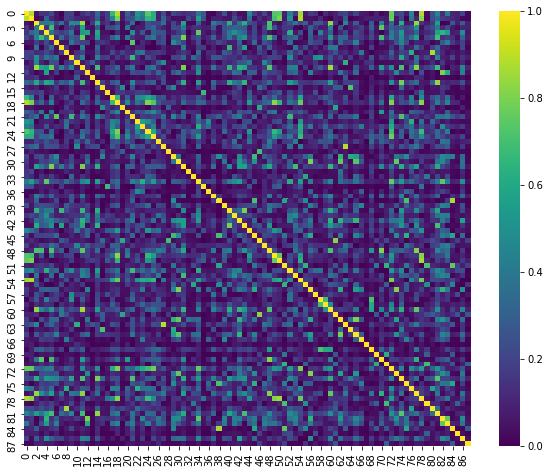

In [20]:
plt.figure(figsize=(10,8))
sns.heatmap(corrs, cmap='viridis')
plt.show()

In [21]:
variances = []
for col in data.columns[5:]:
    vals = np.array(data[col]).reshape(-1,1).astype('float64')
    scaler = MinMaxScaler()
    scaler.fit(vals)
    variances.append(np.std(scaler.transform(vals))**2)

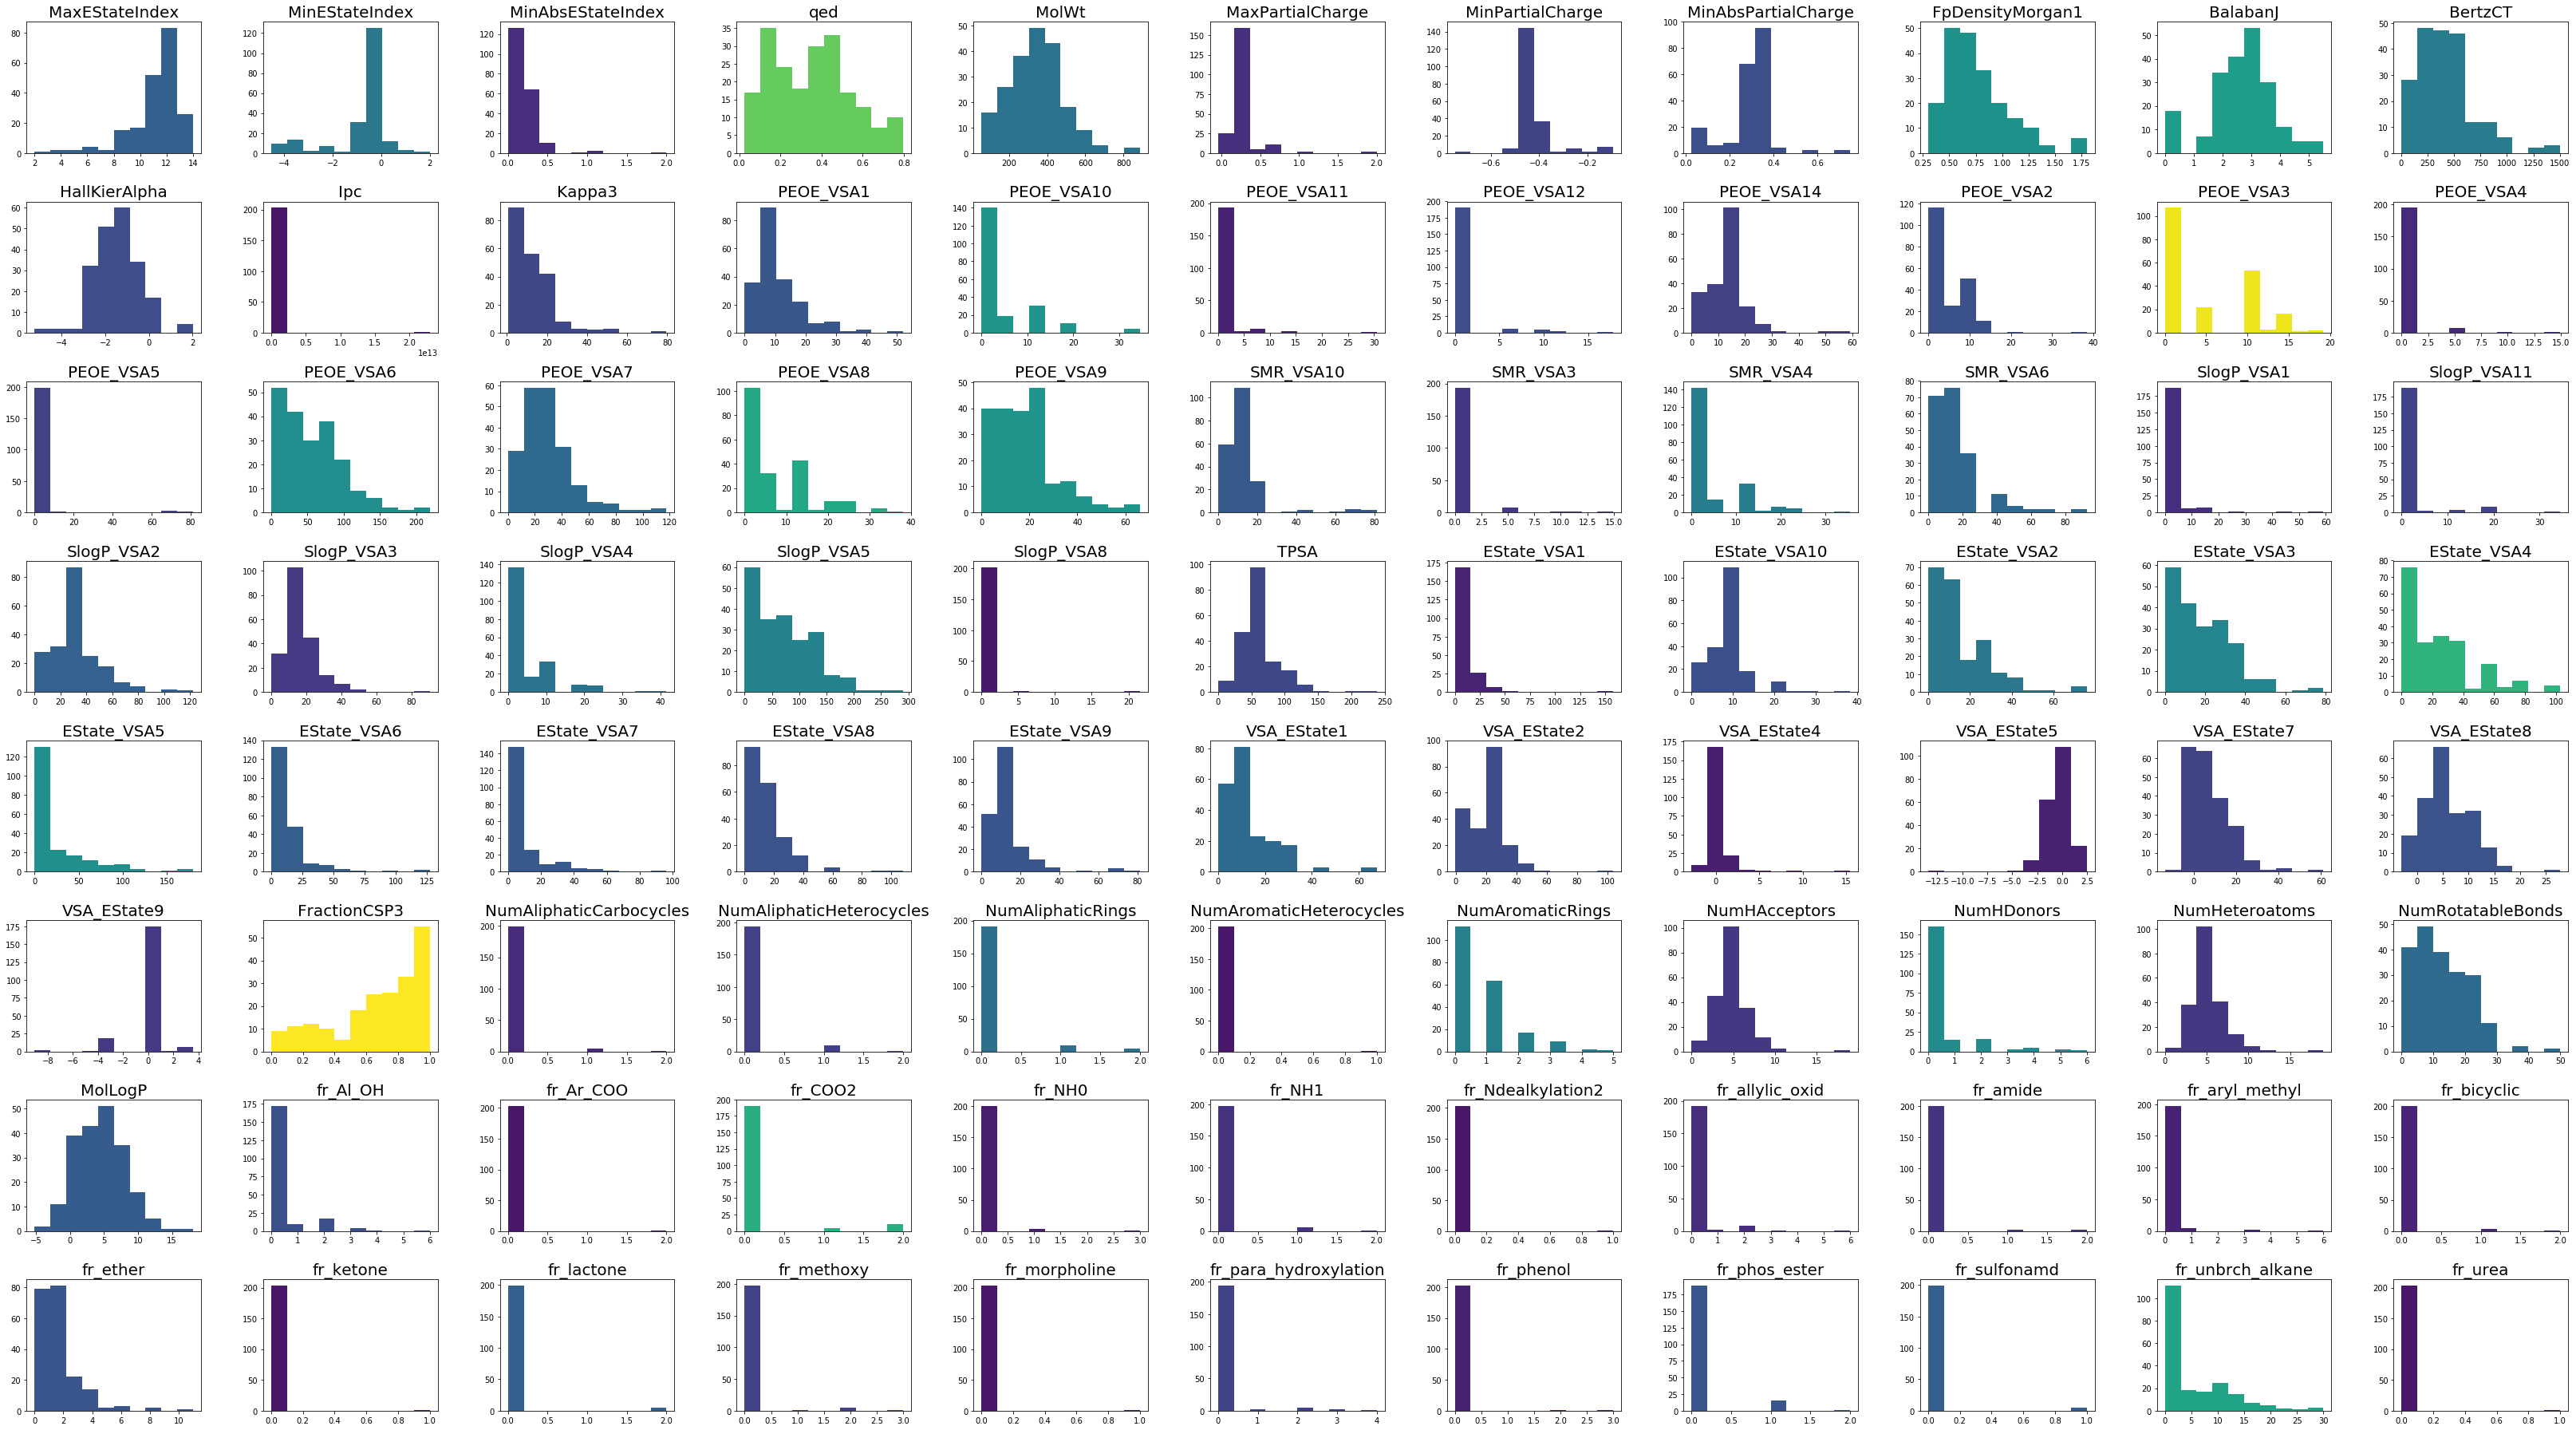

In [22]:
fig, ax = plt.subplots(8,11,figsize=(45,25))
cmap = cm.get_cmap('viridis')
max_var = max(variances)

for i, ax in enumerate(fig.axes):
    ax.hist(data[data.columns[i+5]], color=cmap(variances[i] / max_var))
    ax.set_title(data.columns[i+5], fontsize=20)
fig.tight_layout()
plt.show()

In [23]:
pop_idxs = []
pop_vars = variances.copy()
pop_cols = data.columns[5:].to_list()
for i, var in enumerate(variances):
    if var <= 1e-2:
        pop_idxs.append(i)
for idx in reversed(pop_idxs):
    pop_vars.pop(idx)
    pop_cols.pop(idx)
len(pop_cols)

70

In [24]:
cols = data.columns[:5].to_list() + pop_cols
len(cols)

75

In [25]:
data = data[cols]

In [26]:
corrs = np.zeros((len(pop_cols), len(pop_cols)))
for i in range(len(pop_cols)):
    data1 = data[pop_cols[i]]
    for j in range(len(pop_cols)):
        data2 = data[pop_cols[j]]
        coeff = abs(np.corrcoef(data1, data2)[0][1])
        corrs[i,j] = coeff

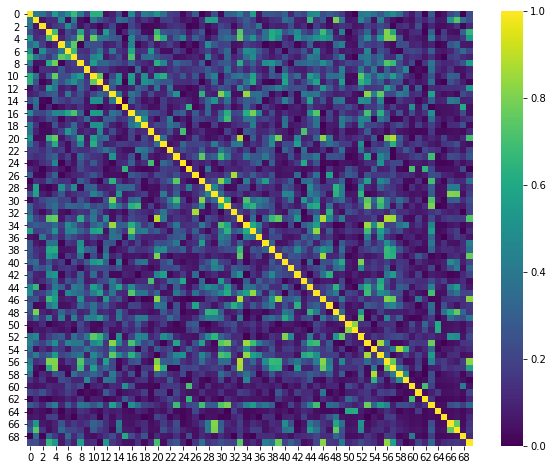

In [27]:
plt.figure(figsize=(10,8))
sns.heatmap(corrs, cmap='viridis')
plt.show()

In [28]:
pop_idxs = []
pop_vars = variances.copy()
pop_cols = data.columns[5:].to_list()
for i, var in enumerate(variances):
    if var <= 1e-3:
        pop_idxs.append(i)
for idx in reversed(pop_idxs):
    pop_vars.pop(idx)
    pop_cols.pop(idx)
cols = data.columns[:5].to_list() + pop_cols
data = data[cols]

In [29]:
#data.to_excel('database/plasticizer_data_v4(rdkit_high_var).xls')

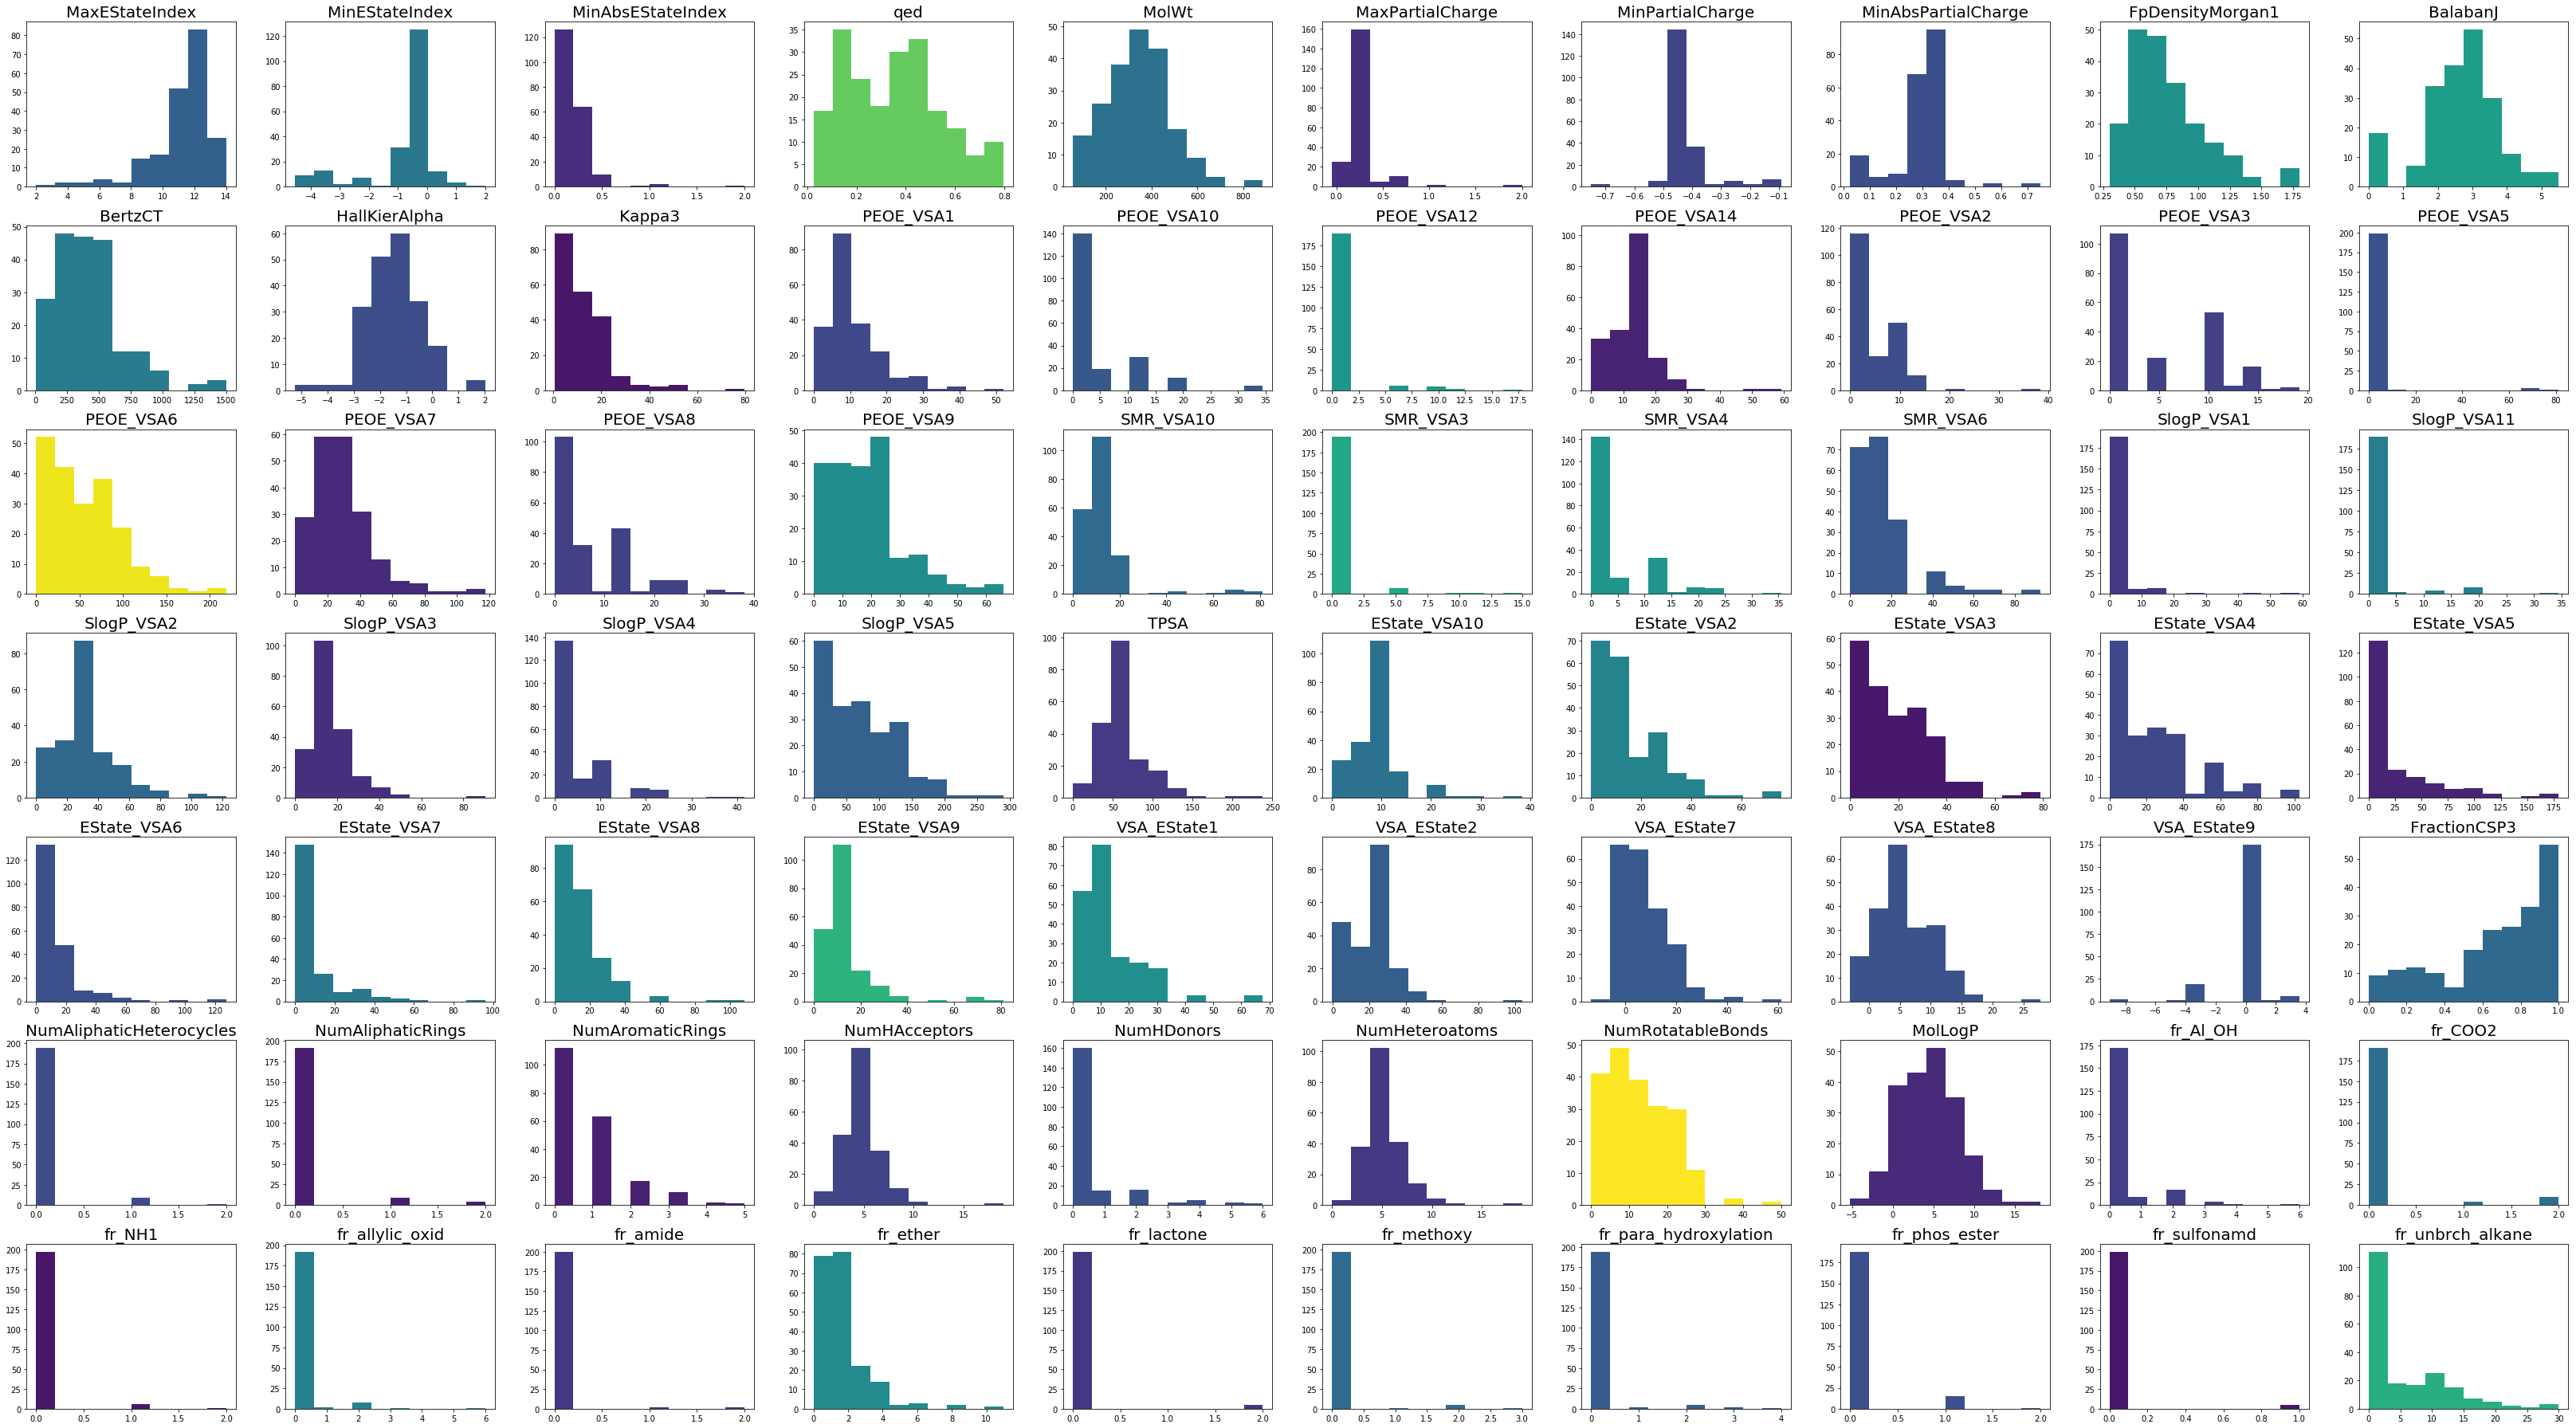

In [30]:
fig, ax = plt.subplots(7,10,figsize=(45,25))
cmap = cm.get_cmap('viridis')
max_var = max(variances)

for i, ax in enumerate(fig.axes):
    ax.hist(data[data.columns[i+5]], color=cmap(variances[i] / max_var))
    ax.set_title(data.columns[i+5], fontsize=20)
fig.tight_layout()
plt.show()

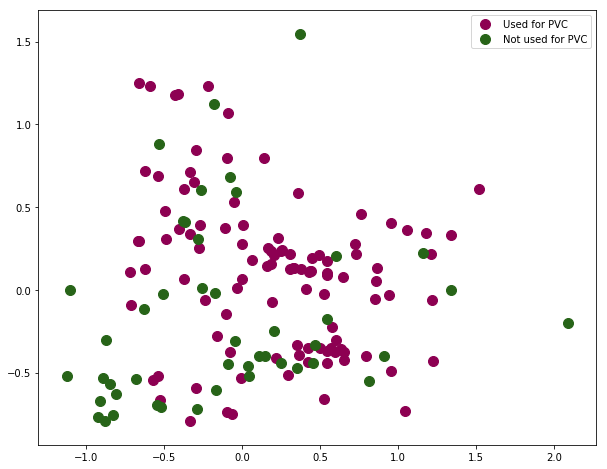

In [31]:
pca_data = data.iloc[:,5:].to_numpy()
scaler = MinMaxScaler()
pca_data = scaler.fit_transform(pca_data)
pca = PCA(n_components=2)
pca.fit(pca_data)
ics = pca.transform(pca_data)

uses = data['Used for Polymeric Materials'].values
data['Used for Polymeric Materials'].value_counts()
used_for_pvc = []
for use in uses:
    if pd.isnull(use):
        used_for_pvc.append(0)
    elif 'PVC' in use:
        used_for_pvc.append(1)
    else:
        used_for_pvc.append(-1)

# cmap = ['#1E77B4', '#FF7F0D', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E277C2', '#7F7F7F', '#BCBD22', '#12BECE']
# color_key = []
# for cat in cats:
#     if cat == 'Phthalates':
#         color_key.append(cmap[0])
#     elif cat == 'Glycols':
#         color_key.append(cmap[1])
#     elif cat == 'Phosphates':
#         color_key.append(cmap[2])
#     elif cat == 'Benzoates':
#         color_key.append(cmap[3])
#     elif cat == 'Adipates':
#         color_key.append(cmap[4])
#     elif cat == 'Polymeric Plasticizers':
#         color_key.append(cmap[5])
#     elif cat == 'Trimellitates':
#         color_key.append(cmap[6])
#     elif cat == 'Citrates':
#         color_key.append(cmap[9])
#     elif cat == 'Sebacates':
#         color_key.append(cmap[8])
#     else:
#         color_key.append(cmap[7])

used_for_pvc = np.array(used_for_pvc)

cmap = ['#8D0052', '#276418']

fig = plt.figure(figsize=(10,8))
plt.scatter(ics[np.where(used_for_pvc==1),0], ics[np.where(used_for_pvc==1),1], color=cmap[0], s=100, alpha=1, label='Used for PVC')
plt.scatter(ics[np.where(used_for_pvc==0),0], ics[np.where(used_for_pvc==0),1], color=cmap[1], s=100, alpha=1, label='Not used for PVC')
plt.legend(loc='best')
plt.show()


# Analyzing on Random Subset of GDB-17

In [32]:
gdb17 = pd.read_pickle('database/gdb17_5mil.pkl') # note this file is not on github due to its size

In [33]:
gdb17 = gdb17[data.columns[5:]]

In [34]:
gdb_data = gdb17.sample(n=500).to_numpy()

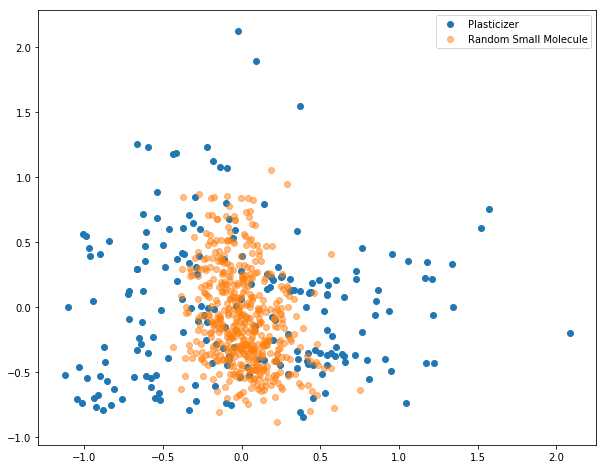

In [35]:
# Plasticizer only PCA

scaler = MinMaxScaler()
gdb_data = scaler.fit_transform(gdb_data)
gdb_ics = pca.transform(gdb_data)

fig = plt.figure(figsize=(10,8))
plt.scatter(ics[:,0], ics[:,1], label='Plasticizer')
plt.scatter(gdb_ics[:,0], gdb_ics[:,1], label='Random Small Molecule', alpha=0.5)
plt.legend(loc='best')
plt.show()

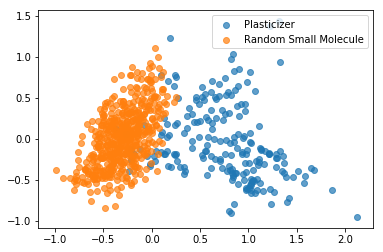

In [36]:
# Joint PCA
pca_data = data.iloc[:,5:].to_numpy()
gdb_data = gdb17.sample(n=500).to_numpy()
joint_data = np.concatenate([pca_data, gdb_data], axis=0)

scaler = MinMaxScaler()
joint_data = scaler.fit_transform(joint_data)

joint_pca = PCA(n_components=2)
joint_pca.fit(joint_data)
joint_ics = joint_pca.transform(joint_data)

plt.scatter(joint_ics[:204,0], joint_ics[:204,1], label='Plasticizer', alpha=0.7)
plt.scatter(joint_ics[204:,0], joint_ics[204:,1], label='Random Small Molecule', alpha=0.7)
plt.legend(loc='best')
plt.show()

# Incorporating Cargill Data to DB

In [2]:
acd = pd.read_excel('database/cargill_data.xlsx')
rdkit = pd.read_excel('database/plasticizer_data_v4(rdkit).xls')

In [7]:
acd = acd.drop('Unnamed: 0', axis=1)

In [13]:
acd = acd[acd.columns[1:]]

In [16]:
acd.columns = acd.iloc[0]

In [18]:
acd = acd.drop('Unnamed: 1')

In [20]:
acd = acd.reset_index(drop=True)

In [27]:
cols = []
for col in acd.columns:
    cols.append(col)
    
for i, col in enumerate(cols):
    col = col.rstrip()
    if col[-1] == ':':
        cols[i] = col[:-1]
acd.columns = cols

In [72]:
# Composition columns

all_atoms = []
for comp in acd['Composition']:
    comp = comp.split(' ')
    for atom in comp:
        atom = atom.split('(')[0]
        all_atoms.append(atom.lower())
all_atoms = list(set(all_atoms))
comp_cols = {}
for x in all_atoms:
    comp_cols[x+'_comp'] = []

for comp in acd['Composition']:
    comp = comp.split(' ')
    atoms = []
    concs = []
    for conc in comp:
        atom = conc.split('(')[0].lower()
        conc = conc.split('(')[1][:-2]
        atoms.append(atom)
        concs.append(conc)
    for all_atom in all_atoms:
        if all_atom in atoms:
            comp_cols[all_atom+'_comp'].append(float(concs[atoms.index(all_atom)]))
        else:
            comp_cols[all_atom+'_comp'].append(0)            

In [64]:
acd = acd.drop('Dielectric Constant', axis=1)

In [66]:
acd = acd.drop(acd.columns[-9:], axis=1)

In [74]:
numeric_cols = {}

for col in acd.columns[3:-1]:
    numeric_cols[col] = []
    for val in acd[col]:
        val = val.split(' ')
        if val[0] == 'Not':
            numeric_cols[col].append(np.nan)
        else:
            numeric_cols[col].append(float(val[0]))

In [75]:
comp_cols = pd.DataFrame(comp_cols)
numeric_cols = pd.DataFrame(numeric_cols)
new_cols = pd.concat([comp_cols, numeric_cols], axis=1)

In [81]:
acd_clean = pd.concat([acd[acd.columns[:2]], comp_cols, numeric_cols, acd['RDBE']], axis=1)

In [85]:
all_data = pd.concat([rdkit, acd_clean], axis=1, sort=False)
all_data = all_data[all_data.columns[1:]]

In [92]:
all_data.to_pickle('database/plasticizer_data_all.pkl')

# Save version with SMILES only

In [3]:
data = pd.read_excel('database/plasticizer_data_v3.xls')

In [5]:
data = data[data.columns[1:]]

In [9]:
data = data[pd.isnull(data['SMILES']) == 0]

In [11]:
data.to_excel('database/plasticizer_data_v3_smiles_only.xls')

# Minor Fixes to v3

In [8]:
data = pd.read_excel('database/plasticizer_data_v3.xls')

In [26]:
used_for_pvc = []
for i, row in data.iterrows():
    if pd.isnull(row['Used for Polymeric Materials']):
        used_for_pvc.append(0)
    elif 'PVC' in row['Used for Polymeric Materials']:
        used_for_pvc.append(1)
    else:
        used_for_pvc.append(0)
data['Used for PVC'] = pd.Series(used_for_pvc)

In [13]:
smiles = []
for i, row in data.iterrows():
    print(i)
    cas = row['CAS Registry No.']
    url = "https://cactus.nci.nih.gov/chemical/structure/{}/smiles".format(cas)
    r = requests.get(url)
    if r.status_code == 404:
        smile = np.nan
    else:
        smile = r.text
    smiles.append(smile)
data['SMILES'] = pd.Series(smiles)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [27]:
dup_smiles = np.array(data['SMILES'].value_counts().index.to_list())
dup_counts = data['SMILES'].value_counts().values

dup_smiles = dup_smiles[dup_counts > 1]
    
drop_idxs = []
for smile in dup_smiles:
    drop_idxs.append(data[data['SMILES'] == smile].index[1:].to_list())

for drop_idx in drop_idxs:
    data.drop(drop_idx, 0, inplace=True)

In [29]:
data

,Unnamed: 0,Aggregate State at 25°C,CAS Registry No.,Chemical Category,Color,EC No.,"Flash Point Temperature, °C",HMIS Fire,HMIS Health,HMIS Personal protection,...,UN Safety Phrases,Used for Polymeric Materials,Used for Products,Flash Point Method,"Boiling Point, °C","Density, kg/m3",Plasticizer name,SMILES,Has CAS,Used for PVC
0,0,Liquid,122-62-3,Sebacates,Colorless,204-558-8,227,0.0,0.0,"Chemical-resistant gloves, eye protection",...,"23,27,44","PVC, chlorinated & nitrile rubbers","Frost-resisting cable, aircraft & car interior...",NaN,NaN,NaN,Chevron ParaLux Process Oil 2401,CCCCC(CC)COC(=O)CCCCCCCCC(=O)OCC(CC)CCCC,1.0,1.0
1,1,"Liquid, oily",28553-12-0,Phthalates,Colorless to yellow,271-090-9,NaN,1.0,1.0,NaN,...,"27,44,53",PVC,"Artificial leather, seats, films, electrical c...",NaN,NaN,NaN,Cimplast DB100,CC(C)CCCCCCOC(=O)c1ccccc1C(=O)OCCCCCCC(C)C,1.0,1.0
2,2,Powder,9084-06-4,Superplasticizers,Dark brown,NaN,NaN,NaN,NaN,"Safety goggles, protective gloves & clothing",...,"22,26,27,39",Concrete,Concrete blocks,NaN,NaN,NaN,Butylphthalyl Butyl Glycolate,[Na+].[Na+].[O-][S](=O)(=O)c1ccc2c(Cc3cccc4cc(...,1.0,0.0
3,3,NaN,84-74-2,Phthalates,NaN,201-557-4,NaN,1.0,2.0,"Safety glasses, protective gloves, lab. coat",...,53-45-61,PVC,"Films, electrical cords, synthetic leather",NaN,NaN,NaN,CITGO Procoil 950,CCCCOC(=O)c1ccccc1C(=O)OCCCC,1.0,1.0
4,4,"Liquid, oily",141-04-8,Adipates,Clear,205-450-3,160,1.0,1.0,"Safety glasses, gloves, lab. coat",...,"9,23,36,51","CAB, CN, VAC, PVC, PAVC","Coatings, adhesives, cable & wire, nail enamel",COC,NaN,NaN,Carbowax MPEG 550,CC(C)COC(=O)CCCCC(=O)OCC(C)C,1.0,1.0
5,5,Liquid,70983-82-3,Epoxides,"Clear, pale yellow",NaN,NaN,NaN,NaN,NaN,...,NaN,PVC,"Tube, pipe, blood bags, bottles, food wrap",NaN,NaN,NaN,Carbowax PEGs 1000,NaN,1.0,1.0
6,6,Liquid,9003-13-8,Glycols,Colorless to pale yellow,NaN,221,1.0,1.0,"Safety goggles, chemically resistant gloves",...,26-36,"NC, vinyl resins","Coatings, lacquers",COC,>200.0 (decomposes),962 (40°C); 913 (100°C),Ceraphyl 41,CCCCOCC(C)OCC(C)O,1.0,0.0
7,7,Liquid,68515-51-5,Phthalates,"Clear, colorless",NaN,NaN,NaN,NaN,"Safety glasses, protective gloves, protective ...",...,"26,27,44,53",PVC,NaN,NaN,NaN,>974 (20°C),CITGO Tufflo Oil 6006,NaN,1.0,1.0
8,8,Liquid,68937-41-7,Phosphates,Clear,NaN,257,1.0,1.0,"Chem. safety goggles, butyl gloves, apron, rub...",...,"9,22,39,51","PVC, PU, syntetic rubber","Coatings, cables, wall coverings, flooring",PMCC,>220.0 @ 0.53 kPa,">1,127 (20°C)",CITGO Procoil 8240,CC(C)c1ccc(O[P](=O)(Oc2ccc(cc2)C(C)C)Oc3ccc(cc...,1.0,1.0
9,9,Liquid,120-55-8,Benzoates,Clear,204-407-6,199,1.0,1.0,"Safety glasses, gloves, lab. coat",...,"24,26,39","PVAc, PVC & wide range of others",NaN,COC,>230 (decomposes),"1,174 (25°C)",Cereclor 51L,O=C(OCCOCCOC(=O)c1ccccc1)c2ccccc2,1.0,1.0


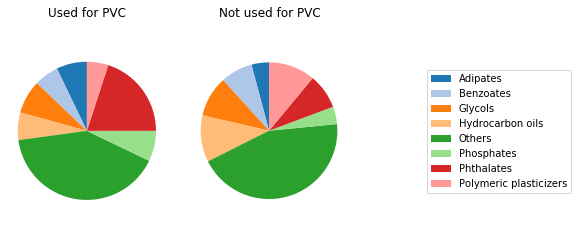

In [30]:
pvc_true_allcat = data[data['Used for PVC'] == 1.0]['Chemical Category'].value_counts()
pvc_false_allcat = data[data['Used for PVC'] == 0.0]['Chemical Category'].value_counts()

high_freq_cats = []
for cat in pvc_true_allcat.index.to_list():
    if pvc_true_allcat[cat] >= 10:
        high_freq_cats.append(cat)
for cat in pvc_false_allcat.index.to_list():
    if pvc_false_allcat[cat] >= 10:
        high_freq_cats.append(cat)
high_freq_cats = sorted(list(set(high_freq_cats)))

true_data_dict = {}
false_data_dict = {}
for cat in high_freq_cats:
    true_data_dict[cat] = 0
    false_data_dict[cat] = 0
    
for cat in pvc_true_allcat.index.to_list():
    if cat in high_freq_cats:
        true_data_dict[cat] += pvc_true_allcat[cat]
    else:
        true_data_dict['Others'] += pvc_true_allcat[cat]

for cat in pvc_false_allcat.index.to_list():
    if cat in high_freq_cats:
        false_data_dict[cat] += pvc_false_allcat[cat]
    else:
        false_data_dict['Others'] += pvc_false_allcat[cat]

true_sizes = true_data_dict.values()
false_sizes = false_data_dict.values()
true_data_dict, true_sizes

colors = plt.cm.tab20((np.arange(20).astype(int)))
fig, axs = plt.subplots(1, 2)
axs[0].pie(true_sizes, startangle=90, colors=colors)
axs[0].axis('equal')
axs[0].set_title('Used for PVC')
wedges, texts = axs[1].pie(false_sizes, startangle=90, colors=colors)
axs[1].axis('equal')
axs[1].legend(wedges, false_data_dict.keys(), loc='center left', bbox_to_anchor=(1.5, 0, 0.5, 1))
axs[1].set_title('Not used for PVC')
plt.show()

In [31]:
has_smiles = []
for i, row in data.iterrows():
    if pd.isnull(row['SMILES']):
        has_smiles.append(0)
    else:
        has_smiles.append(1)
data['Has SMILES'] = pd.Series(has_smiles)

/Users/prguser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/prguser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


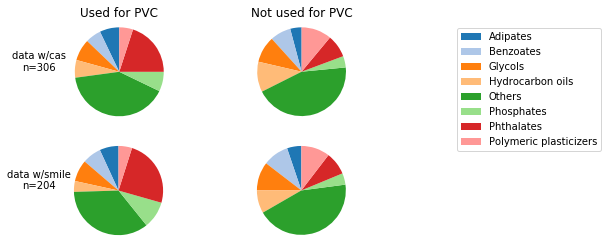

In [34]:
pvc_true_smcat = data[data['Has SMILES'] == 1][data['Used for PVC'] == 1.0]['Chemical Category'].value_counts()
pvc_false_smcat = data[data['Has SMILES'] == 1][data['Used for PVC'] == 0.0]['Chemical Category'].value_counts()

true_data_dict = {}
false_data_dict = {}
for cat in high_freq_cats:
    true_data_dict[cat] = 0
    false_data_dict[cat] = 0
    
for cat in pvc_true_smcat.index.to_list():
    if cat in high_freq_cats:
        true_data_dict[cat] += pvc_true_smcat[cat]
    else:
        true_data_dict['Others'] += pvc_true_smcat[cat]

for cat in pvc_false_smcat.index.to_list():
    if cat in high_freq_cats:
        false_data_dict[cat] += pvc_false_smcat[cat]
    else:
        false_data_dict['Others'] += pvc_false_smcat[cat]

true_sizes_sm = true_data_dict.values()
false_sizes_sm = false_data_dict.values()

colors = plt.cm.tab20((np.arange(20).astype(int)))
fig, axs = plt.subplots(2, 2)
axs[0,0].pie(true_sizes, startangle=90, colors=colors)
axs[0,0].axis('equal')
axs[0,0].set_title('Used for PVC')
axs[0,0].set_ylabel('data w/cas\nn=306', rotation=0)
wedges, texts = axs[0,1].pie(false_sizes, startangle=90, colors=colors)
axs[0,1].axis('equal')
axs[0,1].legend(wedges, false_data_dict.keys(), loc='left', bbox_to_anchor=(2.0, 0, 0.5, 1))
axs[0,1].set_title('Not used for PVC')
axs[1,0].pie(true_sizes_sm, startangle=90, colors=colors)
axs[1,0].axis('equal')
axs[1,0].set_ylabel('data w/smile\nn=204', rotation=0)
axs[1,1].pie(false_sizes_sm, startangle=90, colors=colors)
axs[1,1].axis('equal')
plt.show()

In [36]:
data = data[data.columns[1:]]

In [39]:
data.drop(columns=['Has CAS'], inplace=True)

/Users/prguser/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [41]:
data.to_excel('database/plasticizer_data_v3.xls')

# More cleaning (removing duplicates, mixtures, v2->v3)

In [110]:
og_data = pd.read_excel('database/plasticizer_data_v2.xls')
new_data = pd.read_excel('database/new_pdf_data.xls')
og_data = og_data[og_data.columns[1:]]
new_data = new_data[new_data.columns[1:]]
full_data = pd.concat([og_data, new_data])
full_data.index = pd.RangeIndex(len(full_data.index))

In [111]:
full_data.drop(28, 0, inplace=True)

In [112]:
full_data.drop(30, 0, inplace=True)

In [113]:
new_row1 = [np.nan, '27138-31-4', 'Benzoates', np.nan, np.nan, '>230', np.nan, np.nan, np.nan, np.nan, 'Velsicol Chemical Corporation', 'C20H22O5', '342.39', np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, '1.12', np.nan, np.nan, np.nan, np.nan, 'PVC, PVAc', np.nan, np.nan, '232', np.nan, 'Oxydipropyl dibenzoate', np.nan, np.nan]
new_row1 = pd.DataFrame([new_row1], columns=full_data.columns, index=[845])

new_row2 = ['liquid', '20587-61-5', 'Benzoates', np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 'Velsicol Chemical Corporation', 'C11H14O4', '210.23', np.nan, np.nan, np.nan, np.nan, 1.16, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 'PVC, PVAc', np.nan, np.nan, np.nan, np.nan, '2-(2-Hydroxyethoxy)ethyl benzoate', np.nan, np.nan]
new_row2 = pd.DataFrame([new_row2], columns=full_data.columns, index=[846])

new_row3 = [np.nan, '32686-95-6', 'Benzoates', np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 'Velsicol Chemical Corporation', 'C13H18O4', '238.28', np.nan, np.nan, np.nan, np.nan, 1.63, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 'PVC, PVAc', np.nan, np.nan, np.nan, np.nan, 'Dipropylene glycol monobenzoate', np.nan, np.nan]
new_row3 = pd.DataFrame([new_row3], columns=full_data.columns, index=[847])
full_data = pd.concat([full_data, new_row1, new_row2, new_row3])
full_data.drop(42, 0, inplace=True)

In [114]:
full_data.drop(54, 0, inplace=True)

In [115]:
new_row1 = list(np.full(33, np.nan))
new_row1[1] = '70-55-3'
new_row1[2] = 'Sulfonamides'
new_row1[-3] = 'p-Toluenesulfonamide'
new_row1[-8] = 'Melamine, urea, phenolic, polyamide'
new_row1 = pd.DataFrame([new_row1], columns=full_data.columns, index=[848])

new_row2 = list(np.full(33, np.nan))
new_row2[1] = '88-19-3'
new_row2[2] = 'Sulfonamides'
new_row2[-3] = 'o-Toluenesulfonamide'
new_row2[-8] = 'Melamine, urea, phenolic, polyamide'
new_row2 = pd.DataFrame([new_row2], columns=full_data.columns, index=[849])
full_data = pd.concat([full_data, new_row1, new_row2])
full_data.drop(79, 0, inplace=True)

In [116]:
new_row1 = list(np.full(33, np.nan))
new_row1[1] = '197178-94-2'
new_row1[2] = 'Benzoates'
new_row1[-3] = '(2-Propenyloxy)propylbenzoate'
new_row1[-8] = 'PVC'
new_row1 = pd.DataFrame([new_row1], columns=full_data.columns, index=[850])

new_row2 = list(np.full(33, np.nan))
new_row2[1] = '125457-59-2'
new_row2[2] = 'Benzoates'
new_row2[-3] = '3-(1-hydroxypropoxy)propyl benzoate'
new_row2[-8] = 'PVC'
new_row2 = pd.DataFrame([new_row2], columns=full_data.columns, index=[851])
full_data = pd.concat([full_data, new_row1, new_row2])
full_data.drop(92, 0, inplace=True)

In [118]:
new_row1 = list(np.full(33, np.nan))
new_row1[1] = '102-76-1'
new_row1[2] = 'Others'
new_row1[-3] = 'Triacetin'
new_row1 = pd.DataFrame([new_row1], columns=full_data.columns, index=[852])
full_data = pd.concat([full_data, new_row1])
full_data.drop(107, 0, inplace=True)

In [121]:
full_data.drop(114, 0, inplace=True)

In [129]:
full_data.drop(137, 0, inplace=True)

In [133]:
full_data.drop(148, 0, inplace=True)

In [137]:
new_row1 = list(np.full(33, np.nan))
new_row1[1] = '2522-68-3'
new_row1[2] = 'Glycols'
new_row1[-3] = 'PEG'
new_row1 = pd.DataFrame([new_row1], columns=full_data.columns, index=[853])
full_data = pd.concat([full_data, new_row1])
full_data.drop(162, 0, inplace=True)

In [141]:
full_data.drop(254, 0, inplace=True)

In [145]:
full_data.drop(265, 0, inplace=True)

In [149]:
full_data.drop(335, 0, inplace=True)

In [160]:
new_row1 = list(np.full(33, np.nan))
new_row1[1] = '2528-36-1'
new_row1[2] = 'Phosphates'
new_row1[-3] = 'Dibutyl phenyl phosphate'
new_row1 = pd.DataFrame([new_row1], columns=full_data.columns, index=[854])

new_row2 = list(np.full(33, np.nan))
new_row2[1] = '56-81-5'
new_row2[2] = 'Glycols'
new_row2[-3] = 'Glycerol'
new_row2 = pd.DataFrame([new_row2], columns=full_data.columns, index=[855])

new_row3 = list(np.full(33, np.nan))
new_row3[1] = '111381-91-0'
new_row3[2] = 'Phthalates'
new_row3[-3] = '1,2-Benzenedicarboxylic acid, branched'
new_row3[-8] = 'PVC'
new_row3 = pd.DataFrame([new_row3], columns=full_data.columns, index=[856])

new_row4 = list(np.full(33, np.nan))
new_row4[1] = '111381-89-6'
new_row4[2] = 'Phthalates'
new_row4[-3] = '1,2-Benzenedicarboxylic acid, linear'
new_row4[-8] = 'PVC'
new_row4 = pd.DataFrame([new_row4], columns=full_data.columns, index=[857])

new_row5 = list(np.full(33, np.nan))
new_row5[1] = '68515-44-6'
new_row5[2] = 'Phthalates'
new_row5[-3] = '1,2-Benzenedicarboxylic acid, v3'
new_row5[-8] = 'PVC'
new_row5 = pd.DataFrame([new_row5], columns=full_data.columns, index=[858])

new_row6 = list(np.full(33, np.nan))
new_row6[1] = '26446-35-4'
new_row6[2] = 'Glycols'
new_row6[-3] = 'Monoacetin'
new_row6 = pd.DataFrame([new_row6], columns=full_data.columns, index=[859])

new_row7 = list(np.full(33, np.nan))
new_row7[1] = '108171-26-2'
new_row7[2] = 'Chlorinated paraffins'
new_row7[-3] = 'Chlorinated paraffin'
new_row7[-8]= 'PVC, PU'
new_row7 = pd.DataFrame([new_row7], columns=full_data.columns, index=[860])

new_row8 = list(np.full(33, np.nan))
new_row8[1] = '2752-95-6'
new_row8[2] = 'Phosphates'
new_row8[-3] = 'Butyl diphenyl phosphate'
new_row8 = pd.DataFrame([new_row8], columns=full_data.columns, index=[861])

new_row9 = list(np.full(33, np.nan))
new_row9[1] = '26446-35-5'
new_row9[2] = 'Glycols'
new_row9[-3] = 'Glycerol monoacetate'
new_row9[-8] = 'Cellulosics'
new_row9 = pd.DataFrame([new_row9], columns=full_data.columns, index=[862])

new_row10 = list(np.full(33, np.nan))
new_row10[1] = '111381-90-9'
new_row10[2] = 'Phthalates'
new_row10[-3] = '1,2-Benzenedicarboxylic acid, v4'
new_row10[-8] = 'PVC'
new_row10 = pd.DataFrame([new_row10], columns=full_data.columns, index=[863])

new_row11 = list(np.full(33, np.nan))
new_row11[1] = '25395-31-7'
new_row11[2] = 'Glycols'
new_row11[-3] = 'Diacetin'
new_row11[-8] = 'Cellulosics'
new_row11 = pd.DataFrame([new_row11], columns=full_data.columns, index=[864])
full_data = pd.concat([full_data, new_row1, new_row2, new_row3, new_row4, new_row5, new_row6, new_row7, new_row8, new_row9, new_row10, new_row11])

In [164]:
mult_idxs = []
mults = []
all_cas = []
for i, row in full_data.iterrows():
    cas = row['CAS Registry No.']
    if ',' in cas or ';' in cas:
        if ',' in cas:
            cas = cas.split(',')
        elif ';' in cas:
            cas = cas.split(';')
        for j, c in enumerate(cas):
            if '&' in c:
                c = c.split('&')
                cas.pop(j)
                for val in c:
                    cas.append(val)
        for k, val in enumerate(cas):
            cas[k] = cas[k].rstrip().lstrip()
        mults.append(cas)
        mult_idxs.append(i)
    else:
        all_cas.append(cas)

full_data.drop(mult_idxs, 0, inplace=True)

In [165]:
full_data

,Aggregate State at 25°C,CAS Registry No.,Chemical Category,Color,EC No.,"Flash Point Temperature, °C",HMIS Fire,HMIS Health,HMIS Personal protection,HMIS Reactivity,...,UN Risk Phrases,UN Safety Phrases,Used for Polymeric Materials,Used for Products,Flash Point Method,"Boiling Point, °C","Density, kg/m3",Plasticizer name,SMILES,Has CAS
0,Liquid,122-62-3,Sebacates,Colorless,204-558-8,227,0.0,0.0,"Chemical-resistant gloves, eye protection",0.0,...,22,"23,27,44","PVC, chlorinated & nitrile rubbers","Frost-resisting cable, aircraft & car interior...",NaN,NaN,NaN,Chevron ParaLux Process Oil 2401,CCCCC(CC)COC(=O)CCCCCCCCC(=O)OCC(CC)CCCC,1.0
1,"Liquid, oily",28553-12-0,Phthalates,Colorless to yellow,271-090-9,NaN,1.0,1.0,NaN,0.0,...,"22,33,62","27,44,53",PVC,"Artificial leather, seats, films, electrical c...",NaN,NaN,NaN,Cimplast DB100,CC(C)CCCCCCOC(=O)c1ccccc1C(=O)OCCCCCCC(C)C,1.0
2,Powder,9084-06-4,Superplasticizers,Dark brown,NaN,NaN,NaN,NaN,"Safety goggles, protective gloves & clothing",NaN,...,"22,36/38,42/43","22,26,27,39",Concrete,Concrete blocks,NaN,NaN,NaN,Butylphthalyl Butyl Glycolate,[Na+].[Na+].[O-][S](=O)(=O)c1ccc2c(Cc3cccc4cc(...,1.0
3,NaN,84-74-2,Phthalates,NaN,201-557-4,NaN,1.0,2.0,"Safety glasses, protective gloves, lab. coat",0.0,...,61-50-62,53-45-61,PVC,"Films, electrical cords, synthetic leather",NaN,NaN,NaN,CITGO Procoil 950,CCCCOC(=O)c1ccccc1C(=O)OCCCC,1.0
4,"Liquid, oily",141-04-8,Adipates,Clear,205-450-3,160,1.0,1.0,"Safety glasses, gloves, lab. coat",0.0,...,"20,65,66,67","9,23,36,51","CAB, CN, VAC, PVC, PAVC","Coatings, adhesives, cable & wire, nail enamel",COC,NaN,NaN,Carbowax MPEG 550,CC(C)COC(=O)CCCCC(=O)OCC(C)C,1.0
5,Liquid,70983-82-3,Epoxides,"Clear, pale yellow",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,PVC,"Tube, pipe, blood bags, bottles, food wrap",NaN,NaN,NaN,Carbowax PEGs 1000,No CAS No.,1.0
6,Liquid,9003-13-8,Glycols,Colorless to pale yellow,NaN,221,1.0,1.0,"Safety goggles, chemically resistant gloves",1.0,...,36/37/38,26-36,"NC, vinyl resins","Coatings, lacquers",COC,>200.0 (decomposes),962 (40°C); 913 (100°C),Ceraphyl 41,CCCCOCC(C)OCC(C)O,1.0
7,Liquid,68515-51-5,Phthalates,"Clear, colorless",NaN,NaN,NaN,NaN,"Safety glasses, protective gloves, protective ...",NaN,...,"22,33,36/38,62","26,27,44,53",PVC,NaN,NaN,NaN,>974 (20°C),CITGO Tufflo Oil 6006,No CAS No.,1.0
8,Liquid,68937-41-7,Phosphates,Clear,NaN,257,1.0,1.0,"Chem. safety goggles, butyl gloves, apron, rub...",0.0,...,"20/21/22,33,36/38,43,58","9,22,39,51","PVC, PU, syntetic rubber","Coatings, cables, wall coverings, flooring",PMCC,>220.0 @ 0.53 kPa,">1,127 (20°C)",CITGO Procoil 8240,CC(C)c1ccc(O[P](=O)(Oc2ccc(cc2)C(C)C)Oc3ccc(cc...,1.0
9,Liquid,120-55-8,Benzoates,Clear,204-407-6,199,1.0,1.0,"Safety glasses, gloves, lab. coat",0.0,...,36/38,"24,26,39","PVAc, PVC & wide range of others",NaN,COC,>230 (decomposes),"1,174 (25°C)",Cereclor 51L,No CAS No.,1.0


In [180]:
dup_idxs = np.array(full_data['CAS Registry No.'].value_counts().index.to_list())
dup_counts = full_data['CAS Registry No.'].value_counts().values

idxs = []
for i, count in enumerate(dup_counts):
    if count > 1:
        idxs.append(i)
dup_idxs = dup_idxs[idxs]

drop_idxs = []
for idx in dup_idxs:
    drop_idxs.append(full_data[full_data['CAS Registry No.'] == idx].index[1:].to_list())

for drop_idx in drop_idxs:
    full_data.drop(drop_idx, 0, inplace=True)

In [182]:
full_data.index = pd.RangeIndex(len(full_data.index))

In [184]:
full_data.to_excel('database/plasticizer_data_v3.xls')

# Cleaning raw HTML + smiles

In [37]:
raw_smiles = pd.read_excel('database/Allparsed_files_with_SMILES.xls')

In [40]:
cols = raw_smiles.columns
drop_cols = raw_smiles.columns[:2]
raw_smiles = raw_smiles.drop(columns=drop_cols)
# for col in cols:
#     perc_nan = raw[col].isna().sum() / len(raw[col])
#     if perc_nan >= 0.9:
#         drop_cols.append(col)

In [42]:
col_rename = {}
for col in raw_smiles.columns:
    if col[-1] == ':':
        col_rename[col] = col[:-1]
raw_smiles.rename(columns=col_rename, inplace=True)

In [47]:
has_cas = []
for i, row in raw_smiles.iterrows():
    cas = row['CAS Registry No.']
    if pd.isnull(cas):
        has_cas.append(0)
    else:
        has_cas.append(1)
raw_smiles['Has CAS'] = pd.Series(has_cas)

In [49]:
raw_smiles_cas = raw_smiles[raw_smiles['Has CAS'] == 1]

In [53]:
drop_cols = []
for col in raw_smiles_cas.columns:
    perc_nan = raw_smiles_cas[col].isna().sum() / len(raw_smiles_cas[col])
    if perc_nan >= 0.5:
        drop_cols.append(col)
raw_smiles_cas = raw_smiles_cas.drop(columns=drop_cols)

In [54]:
for col in raw_smiles_cas.columns:
    perc_nan = raw_smiles_cas[col].isna().sum() / len(raw_smiles_cas[col])
    print(col, round(1 - perc_nan, 2))

Aggregate State at 25°C 0.92
CAS Registry No. 1.0
Chemical Category 1.0
Color 0.85
EC No. 0.61
Flash Point Temperature, °C 0.78
HMIS Fire 0.74
HMIS Health 0.74
HMIS Personal protection 0.79
HMIS Reactivity 0.74
Manufacturer 1.0
Molecular Formula 0.6
Molecular Weight 0.71
NFPA Flammability 0.88
NFPA Health 0.88
NFPA Reactivity 0.88
OSHA Hazard Class 0.81
Octanol-Water Partition Coeff., log Kow 0.55
Odor 0.62
Outstanding Properties 0.71
Specific Gravity 0.7
Synonyms 0.99
Theoretical Oxygen Demand, ThOD, g/g 0.51
UN Risk Phrases 0.71
UN Safety Phrases 0.72
Used for Polymeric Materials 0.83
Used for Products 0.61
Flash Point Method 0.64
Boiling Point, °C 0.51
Density, kg/m3 0.5
Plasticizer name 1.0
SMILES 1.0
Has CAS 1.0


In [55]:
raw_smiles_cas.to_excel('database/plasticizer_data_v2.xls')

# Editing CAS

In [3]:
plast_data_cas = pd.read_excel('database/cas_plasticizers.xls')

In [4]:
plast_data_cas

,index,Plasticizer name,CAS Registry No.,Molecular Formula,Chemical Category,Used for Polymeric Materials,Used for Products,Synonyms,Smiles
0,0,Chevron ParaLux Process Oil 2401,122-62-3,C26H50O4,Sebacates,"PVC, chlorinated & nitrile rubbers","Frost-resisting cable, aircraft & car interior...","DOS, DEHS; Dioctyl sebacate; Di-(2-ethylhexyl)...",CCCCC(CC)COC(=O)CCCCCCCCC(=O)OCC(CC)CCCC
1,1,Cimplast DB100,28553-12-0,C26H42O4,Phthalates,PVC,"Artificial leather, seats, films, electrical c...","DINP; Diisononyl phthalate; 1,2-Benzenedicarbo...",CC(C)CCCCCCOC(=O)c1ccccc1C(=O)OCCCCCCC(C)C
2,2,Butylphthalyl Butyl Glycolate,9084-06-4,NaN,Superplasticizers,Concrete,Concrete blocks,"SNF; Naphthalene sulfonate, calcium salt; Naph...",[Na+].[Na+].[O-][S](=O)(=O)c1ccc2c(Cc3cccc4cc(...
3,3,CITGO Procoil 950,84-74-2,C16H22O4,Phthalates,PVC,"Films, electrical cords, synthetic leather","DBP; Di-n-butyl phthalate; 1,2-Benzenedicarbox...",CCCCOC(=O)c1ccccc1C(=O)OCCCC
4,4,Carbowax MPEG 550,141-04-8,C14H26O4,Adipates,"CAB, CN, VAC, PVC, PAVC","Coatings, adhesives, cable & wire, nail enamel","DIBA; Diisobutyl adipate; Hexanedioic acid, bi...",CC(C)COC(=O)CCCCC(=O)OCC(C)C
5,5,Carbowax PEGs 1000,70983-82-3,NaN,Epoxides,PVC,"Tube, pipe, blood bags, bottles, food wrap",Epoxidized linseed fatty acid,NaN
6,6,Ceraphyl 41,9003-13-8,NaN,Glycols,"NC, vinyl resins","Coatings, lacquers",PAG; Polyropylene glycol monobutyl ether; Buto...,CCCCOCC(C)OCC(C)O
7,7,CITGO Tufflo Oil 6006,68515-51-5,NaN,Phthalates,PVC,NaN,"Alkyl phthalate, C6-C10",NaN
8,8,CITGO Procoil 8240,68937-41-7,NaN,Phosphates,"PVC, PU, syntetic rubber","Coatings, cables, wall coverings, flooring",Isopropylated triphenyl phosphate; Triisopropy...,CC(C)c1ccc(O[P](=O)(Oc2ccc(cc2)C(C)C)Oc3ccc(cc...
9,9,Cereclor 51L,120-55-8,C18H18O5,Benzoates,"PVAc, PVC & wide range of others",NaN,"Diethylene glycol dibenzoate; Ethanol, 2,2'-ox...",O=C(OCCOCCOC(=O)c1ccccc1)c2ccccc2


In [173]:
copy_row_idxs = []
mults = []
sings = []
for i, row in plast_data_cas.iterrows():
    mult = row['CAS Registry No.']
    if ',' in mult or ';' in mult:
        if ',' in mult:
            cass = mult.replace(' ','').split(',')
        elif ';' in mult:
            cass = mult.replace(' ','').split(';')
        if '&' in mult:
            for j, cas in enumerate(cass):
                if '&' in cas:
                    new_cas = cas.split('&')
                    cass.pop(j)
            for cas in new_cas:
                cass.append(cas)
        mults.append(cass)
        copy_row_idxs.append(i)
    else:
        sings.append(mult)
# for i, idx in enumerate(reversed(copy_row_idxs)):
#     new_row = pd.Series(plast_data_cas.iloc[idx,:])
#     print(mults[-(i+1)])


for mult in mults:
    for sample in mult:
        sings.append(sample)
cas = list(set(sings))
cas.append('35415-27-1')
cas.append('88-19-7')
cas.append('2915-57-3')
cas.append('70084-70-7')
cas.append('2687-96-9')
cas.append('616-45-5')
cas.append('9004-74-4')
cas.append('117-84-0')
cas.append('68952-33-0')
cas.append('26399-02-0')
cas.append('123-76-2')

if '64741-81-7' in cas:
    print('ye')

ye


In [6]:
no_smile = plast_data_cas[pd.isnull(plast_data_cas['Smiles'])]
no_smile

,index,Plasticizer name,CAS Registry No.,Molecular Formula,Chemical Category,Used for Polymeric Materials,Used for Products,Synonyms,Smiles
5,5,Carbowax PEGs 1000,70983-82-3,NaN,Epoxides,PVC,"Tube, pipe, blood bags, bottles, food wrap",Epoxidized linseed fatty acid,NaN
7,7,CITGO Tufflo Oil 6006,68515-51-5,NaN,Phthalates,PVC,NaN,"Alkyl phthalate, C6-C10",NaN
13,13,Cereclor 63L,37353-75-6,C21H28O4,Others,PVC,NaN,P-BPA; Bisphenol A propoxylate; 3-(4-{1-[4-(3-...,NaN
16,16,Cimplast 115,9038-95-3,NaN,Glycols,"NC, vinyl resins","Coatings, lacquers",PAG; Polyalkylene glycol monobutyl ether,NaN
21,21,CITGO Procoil 965,9003-18-3,(C9H15N)n,Polymeric plasticizers,"PVC flexible & semi-rigid, ASA, EVA, PUR",NaN,NBR; Acrylonitile-butadiene copolymer; Nitrile...,NaN
25,25,CITGO Procoil 915,37353-75-6,C21H28O4,Others,PVC,NaN,P-BPA; Bisphenol A propoxylate; 3-(4-{1-[4-(3-...,NaN
28,28,Chlorowax 63-85,"56803-37-3, 29761-21-5",NaN,Phosphates,"PVC, cellular vinyls","Coatings, films",p-tert-Butylphenyl diphenyl phosphate; Triaryl...,NaN
30,30,Chlorowax 49-320,120-55-8; 120-56-9; 110-27-0,NaN,Benzoates,NaN,NaN,DEGDB; TEGDB; IPM; Diethylene glycol dibenzoat...,NaN
31,31,Castung 103 G-H,9038-95-3,NaN,Glycols,"NC, vinyl resins","Coatings, lacquers",PAG; Polyalkylene glycol monobutyl ether,NaN
39,39,Butanediol,71302-79-9,NaN,Epoxides,PVC,"Tube, pipe, blood bags, bottles, food wrap",Epoxidized linseed fatty acid,NaN


In [8]:
duds = []
mults = []
for cas in no_smile['CAS Registry No.']:
    if ',' in cas or ';' in cas:
        mults.append(cas)
    else:
        duds.append(cas)

In [21]:
missing_smiles = []
for mult in mults:
    if ',' in mult:
        cass = mult.replace(" ",'').split(',')
    elif ';' in mult:
        cass = mult.replace(" ",'').split(';')
    if '&' in mult:
        for i, cas in enumerate(cass):
            if '&' in cas:
                new_cas = cas.split('&')
                cass.pop(i)
        for cas in new_cas:
            cass.append(cas)
    print(cass)
    for cas in cass:
        url = 'https://cactus.nci.nih.gov/chemical/structure/{}/smiles'.format(cas)
        r = requests.get(url)
        if r.status_code == 404:
            smile = np.nan
        else:
            smile = r.text
        print(smile)
        missing_smiles.append(smile)


['56803-37-3', '29761-21-5']
CC(C)(C)c1ccc(O[P](=O)(Oc2ccccc2)Oc3ccccc3)cc1
CC(C)CCCCCCCO[P](=O)(Oc1ccccc1)Oc2ccccc2
['120-55-8', '120-56-9', '110-27-0']
O=C(OCCOCCOC(=O)c1ccccc1)c2ccccc2
O=C(OCCOCCOCCOC(=O)c1ccccc1)c2ccccc2
CCCCCCCCCCCCCC(=O)OC(C)C
['120-55-8', '120-56-9', '271138-31-4', '20587-61-5', '32686-95-6']
O=C(OCCOCCOC(=O)c1ccccc1)c2ccccc2
O=C(OCCOCCOCCOC(=O)c1ccccc1)c2ccccc2
nan
OCCOCCOC(=O)c1ccccc1
nan
['1119-40-0', '106-65-0', '627-93-0']
COC(=O)CCCC(=O)OC
COC(=O)CCC(=O)OC
COC(=O)CCCCC(=O)OC
['70-55-3', '88-19-3']
Cc1ccc(cc1)[S](N)(=O)=O
nan
['120-55-8', '27138-31-4', '20587-61-5', '125457-59-2', '19224-26-1', '197178-94-2']
O=C(OCCOCCOC(=O)c1ccccc1)c2ccccc2
O=C(OCCCOCCCOC(=O)c1ccccc1)c2ccccc2
OCCOCCOC(=O)c1ccccc1
nan
CC(COC(=O)c1ccccc1)OC(=O)c2ccccc2
nan
['111-21-7', '102-76-1']
CC(=O)OCCOCCOCCOC(C)=O
CC(=O)OCC(COC(C)=O)OC(C)=O
['1119-40-0', '106-65-0', '627-93-0']
COC(=O)CCCC(=O)OC
COC(=O)CCC(=O)OC
COC(=O)CCCCC(=O)OC
['120-55-8', '120-56-9', '103-23-1', '20587-61-5']
O=C

# Raw to CAS

In [2]:
raw = pd.read_excel('data/raw_plasticizer_html.xls')
cols = raw.columns
drop_cols = [raw.columns[0]]
for col in cols:
    perc_nan = raw[col].isna().sum() / len(raw[col])
    if perc_nan >= 0.9:
        drop_cols.append(col)

['Unnamed: 0',
 'Volume Resistivity, Ohm cm:',
 'pH:',
 'ADR/RID Class:',
 'EPA Code:',
 'ICAO/IATA Class:',
 'IMDG Class:',
 'NIOSH-IDLH, ppm:',
 'OSHA PEL, mg/m3:',
 'Iodine Value, g/100 g:',
 'Oxirane Oxygen, wt. %:',
 'Linear Coefficient of Expansion at 55°C, m/m °C:',
 'Surface Tension, mN/m:',
 'ACGIH, mg/m3:',
 'DOT Class:',
 'Daphnia Magna, mg/L:',
 'Phosphorus Content, wt. %:',
 'Rainbow Trout, 96-h LC50, mg/L:',
 'Rat Dermal, LD50, mg/kg:',
 'Rat Inhalation, LC50, mg/kg:',
 'Biodegradation Probability:',
 'Chemical Oxygen Demand, COD, g/g:',
 'Mouse Inhalation, LC50, ppm:',
 'Solubility in Water at 25°C, g/L:',
 'Saponification Value, mg KOH/g:',
 'Ester Content, wt. %:',
 'Hydroxyl Number, mg KOH/g:',
 'Fathead Minnow, 96-h LC50, mg/L:',
 'Clash-Berg Temperature, °C:',
 'Extraction, oil #3 48 h at 70°C, 50 phr, %:',
 'Extraction, olive oil 48 h at 70°C, 50 phr, %:',
 'Extraction, soapy water 48 h at 70°C, 50 phr, %:',
 'Shore A Hardness:',
 'Aniline Point, °C:',
 'Carcinogen

In [3]:
rem_nan = raw.drop(columns=drop_cols)

In [4]:
col_rename = {}
for col in rem_nan.columns:
    if col[-1] == ':':
        col_rename[col] = col[:-1]
rem_nan.rename(columns=col_rename, inplace=True)

In [5]:
cat_cols = ['Plasticizer name', 'CAS Registry No.', 'Molecular Formula', 'Chemical Category', 'Used for Polymeric Materials', 'Used for Products', 'Synonyms']
plast_data = rem_nan[cat_cols].copy()


In [6]:
used_for_pvc = []
for i, row in plast_data.iterrows():
    if pd.isnull(row['Used for Polymeric Materials']):
        used_for_pvc.append(np.nan)
    elif 'PVC' in row['Used for Polymeric Materials']:
        used_for_pvc.append(1)
    else:
        used_for_pvc.append(0)
plast_data['Used for PVC'] = pd.Series(used_for_pvc)

In [7]:
no_cas = plast_data[plast_data['CAS Registry No.'].isnull()].index.tolist()
has_cas = []
for i, row in plast_data.iterrows():
    if i in no_cas:
        has_cas.append(0)
    else:
        has_cas.append(1)
plast_data['Has CAS'] = pd.Series(has_cas)

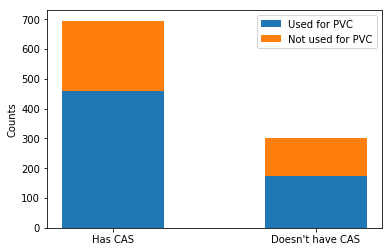

In [17]:
pvc_vs_cas = plast_data.groupby(['Used for PVC', 'Has CAS'])['Used for PVC'].count().unstack('Has CAS')

pvc_vs_cas.iloc[:,0]
pvc_true = [pvc_vs_cas.iloc[1,1], pvc_vs_cas.iloc[1,0]]
pvc_false = [pvc_vs_cas.iloc[0,1], pvc_vs_cas.iloc[0,0]]

ind = np.arange(2)
width = 0.5
p1 = plt.bar(ind, pvc_true, width)
p2 = plt.bar(ind, pvc_false, width, bottom=pvc_true)

plt.xticks(ind, ['Has CAS', "Doesn't have CAS"])
plt.ylabel('Counts')
plt.legend((p1[0], p2[0]), ['Used for PVC', 'Not used for PVC'])
plt.show()

In [ ]:
pvc_true_allcat = plast_data[plast_data['Used for PVC'] == 1.0]['Chemical Category'].value_counts()
pvc_false_allcat = plast_data[plast_data['Used for PVC'] == 0.0]['Chemical Category'].value_counts()

high_freq_cats = []
for cat in pvc_true_allcat.index.to_list():
    if pvc_true_allcat[cat] >= 10:
        high_freq_cats.append(cat)
for cat in pvc_false_allcat.index.to_list():
    if pvc_false_allcat[cat] >= 10:
        high_freq_cats.append(cat)
high_freq_cats = sorted(list(set(high_freq_cats)))

true_data_dict = {}
false_data_dict = {}
for cat in high_freq_cats:
    true_data_dict[cat] = 0
    false_data_dict[cat] = 0
    
for cat in pvc_true_allcat.index.to_list():
    if cat in high_freq_cats:
        true_data_dict[cat] += pvc_true_allcat[cat]
    else:
        true_data_dict['Others'] += pvc_true_allcat[cat]

for cat in pvc_false_allcat.index.to_list():
    if cat in high_freq_cats:
        false_data_dict[cat] += pvc_false_allcat[cat]
    else:
        false_data_dict['Others'] += pvc_false_allcat[cat]

true_sizes = true_data_dict.values()
false_sizes = false_data_dict.values()
true_data_dict, true_sizes

fig, axs = plt.subplots(1, 2)
axs[0].pie(true_sizes, startangle=90)
axs[0].axis('equal')
wedges, texts = axs[1].pie(false_sizes, startangle=90)
axs[1].axis('equal')
axs[1].legend(wedges, false_data

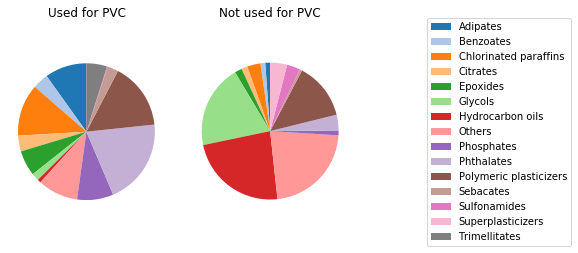

In [63]:
pvc_true_allcat = plast_data[plast_data['Used for PVC'] == 1.0]['Chemical Category'].value_counts()
pvc_false_allcat = plast_data[plast_data['Used for PVC'] == 0.0]['Chemical Category'].value_counts()

high_freq_cats = []
for cat in pvc_true_allcat.index.to_list():
    if pvc_true_allcat[cat] >= 10:
        high_freq_cats.append(cat)
for cat in pvc_false_allcat.index.to_list():
    if pvc_false_allcat[cat] >= 10:
        high_freq_cats.append(cat)
high_freq_cats = sorted(list(set(high_freq_cats)))

true_data_dict = {}
false_data_dict = {}
for cat in high_freq_cats:
    true_data_dict[cat] = 0
    false_data_dict[cat] = 0
    
for cat in pvc_true_allcat.index.to_list():
    if cat in high_freq_cats:
        true_data_dict[cat] += pvc_true_allcat[cat]
    else:
        true_data_dict['Others'] += pvc_true_allcat[cat]

for cat in pvc_false_allcat.index.to_list():
    if cat in high_freq_cats:
        false_data_dict[cat] += pvc_false_allcat[cat]
    else:
        false_data_dict['Others'] += pvc_false_allcat[cat]

true_sizes = true_data_dict.values()
false_sizes = false_data_dict.values()
true_data_dict, true_sizes

colors = plt.cm.tab20((np.arange(20).astype(int)))
fig, axs = plt.subplots(1, 2)
axs[0].pie(true_sizes, startangle=90, colors=colors)
axs[0].axis('equal')
axs[0].set_title('Used for PVC')
wedges, texts = axs[1].pie(false_sizes, startangle=90, colors=colors)
axs[1].axis('equal')
axs[1].legend(wedges, false_data_dict.keys(), loc='center left', bbox_to_anchor=(1.5, 0, 0.5, 1))
axs[1].set_title('Not used for PVC')
plt.show()

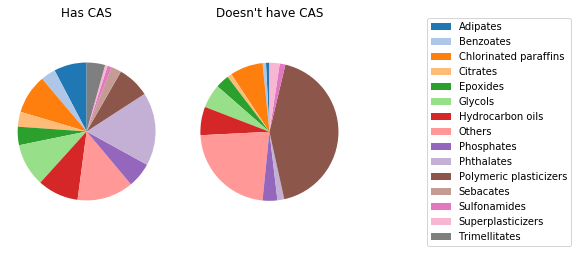

In [64]:
cas_true_allcat = plast_data[plast_data['Has CAS'] == 1]['Chemical Category'].value_counts()
cas_false_allcat = plast_data[plast_data['Has CAS'] == 0]['Chemical Category'].value_counts()

true_data_dict = {}
false_data_dict = {}
for cat in high_freq_cats:
    true_data_dict[cat] = 0
    false_data_dict[cat] = 0
    
for cat in cas_true_allcat.index.to_list():
    if cat in high_freq_cats:
        true_data_dict[cat] += cas_true_allcat[cat]
    else:
        true_data_dict['Others'] += cas_true_allcat[cat]

for cat in cas_false_allcat.index.to_list():
    if cat in high_freq_cats:
        false_data_dict[cat] += cas_false_allcat[cat]
    else:
        false_data_dict['Others'] += cas_false_allcat[cat]

true_sizes = true_data_dict.values()
false_sizes = false_data_dict.values()
true_data_dict, true_sizes

colors = plt.cm.tab20((np.arange(20).astype(int)))
fig, axs = plt.subplots(1, 2)
axs[0].pie(true_sizes, startangle=90, colors=colors)
axs[0].axis('equal')
axs[0].set_title('Has CAS')
wedges, texts = axs[1].pie(false_sizes, startangle=90, colors=colors)
axs[1].axis('equal')
axs[1].legend(wedges, false_data_dict.keys(), loc='center left', bbox_to_anchor=(1.5, 0, 0.5, 1))
axs[1].set_title("Doesn't have CAS")
plt.show()

/Users/prguser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/prguser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


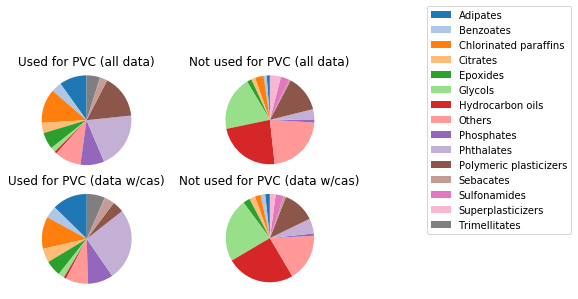

In [74]:
pvc_true_cascat = plast_data[plast_data['Has CAS'] == 1][plast_data['Used for PVC'] == 1.0]['Chemical Category'].value_counts()
pvc_false_cascat = plast_data[plast_data['Has CAS'] == 1][plast_data['Used for PVC'] == 0.0]['Chemical Category'].value_counts()

true_data_dict = {}
false_data_dict = {}
for cat in high_freq_cats:
    true_data_dict[cat] = 0
    false_data_dict[cat] = 0
    
for cat in pvc_true_cascat.index.to_list():
    if cat in high_freq_cats:
        true_data_dict[cat] += pvc_true_cascat[cat]
    else:
        true_data_dict['Others'] += pvc_true_cascat[cat]

for cat in pvc_false_cascat.index.to_list():
    if cat in high_freq_cats:
        false_data_dict[cat] += pvc_false_cascat[cat]
    else:
        false_data_dict['Others'] += pvc_false_cascat[cat]

true_sizes_cas = true_data_dict.values()
false_sizes_cas = false_data_dict.values()

colors = plt.cm.tab20((np.arange(20).astype(int)))
fig, axs = plt.subplots(2, 2)
axs[0,0].pie(true_sizes, startangle=90, colors=colors)
axs[0,0].axis('equal')
axs[0,0].set_title('Used for PVC (all data)')
wedges, texts = axs[0,1].pie(false_sizes, startangle=90, colors=colors)
axs[0,1].axis('equal')
axs[0,1].legend(wedges, false_data_dict.keys(), loc='center left', bbox_to_anchor=(1.5, 0, 0.5, 1))
axs[0,1].set_title('Not used for PVC (all data)')
axs[1,0].pie(true_sizes_cas, startangle=90, colors=colors)
axs[1,0].axis('equal')
axs[1,0].set_title('Used for PVC (data w/cas)')
axs[1,1].pie(false_sizes_cas, startangle=90, colors=colors)
axs[1,1].axis('equal')
axs[1,1].set_title('Not used for PVC (data w/cas)')
plt.show()

In [96]:
plast_data_cas = plast_data[plast_data['Has CAS'] == 1][plast_data.columns[:-2]].copy()
plast_data_cas

,Plasticizer name,CAS Registry No.,Molecular Formula,Chemical Category,Used for Polymeric Materials,Used for Products,Synonyms
0,Chevron ParaLux Process Oil 2401,122-62-3,C26H50O4,Sebacates,"PVC, chlorinated & nitrile rubbers","Frost-resisting cable, aircraft & car interior...","DOS, DEHS; Dioctyl sebacate; Di-(2-ethylhexyl)..."
2,Cimplast DB100,28553-12-0,C26H42O4,Phthalates,PVC,"Artificial leather, seats, films, electrical c...","DINP; Diisononyl phthalate; 1,2-Benzenedicarbo..."
3,Butylphthalyl Butyl Glycolate,9084-06-4,NaN,Superplasticizers,Concrete,Concrete blocks,"SNF; Naphthalene sulfonate, calcium salt; Naph..."
4,CITGO Procoil 950,84-74-2,C16H22O4,Phthalates,PVC,"Films, electrical cords, synthetic leather","DBP; Di-n-butyl phthalate; 1,2-Benzenedicarbox..."
5,Carbowax MPEG 550,141-04-8,C14H26O4,Adipates,"CAB, CN, VAC, PVC, PAVC","Coatings, adhesives, cable & wire, nail enamel","DIBA; Diisobutyl adipate; Hexanedioic acid, bi..."
6,Carbowax PEGs 1000,70983-82-3,NaN,Epoxides,PVC,"Tube, pipe, blood bags, bottles, food wrap",Epoxidized linseed fatty acid
7,Ceraphyl 41,9003-13-8,NaN,Glycols,"NC, vinyl resins","Coatings, lacquers",PAG; Polyropylene glycol monobutyl ether; Buto...
9,CITGO Tufflo Oil 6006,68515-51-5,NaN,Phthalates,PVC,NaN,"Alkyl phthalate, C6-C10"
10,CITGO Procoil 8240,68937-41-7,NaN,Phosphates,"PVC, PU, syntetic rubber","Coatings, cables, wall coverings, flooring",Isopropylated triphenyl phosphate; Triisopropy...
11,Cereclor 51L,120-55-8,C18H18O5,Benzoates,"PVAc, PVC & wide range of others",NaN,"Diethylene glycol dibenzoate; Ethanol, 2,2'-ox..."


In [98]:
smiles = []

for i, row in plast_data_cas.iterrows():
    cas = row['CAS Registry No.']
    url = 'https://cactus.nci.nih.gov/chemical/structure/{}/smiles'.format(cas)
    r = requests.get(url)
    if r.status_code == 404:
        smile = np.nan
    else:
        smile = r.text
    print(i)
    smiles.append(smile)

0
2
3
4
5
6
7
9
10
11
12
14
15
16
17
18
19
21
22
24
25
26
34
35
37
38
41
44
45
46
47
48
50
51
52
54
55
56
57
58
59
61
62
63
66
67
68
69
70
71
73
76
77
80
81
85
86
89
93
95
97
98
99
101
103
104
105
106
109
110
111
112
113
116
117
118
119
123
124
125
126
127
129
130
131
132
133
134
137
138
139
140
141
143
144
145
146
147
148
149
150
151
153
154
156
160
161
162
163
165
169
171
172
174
178
179
180
182
183
184
186
187
188
190
191
192
193
195
197
198
199
200
203
204
206
207
208
209
210
211
212
213
214
215
216
218
219
222
224
225
227
228
230
232
235
236
240
242
243
245
246
248
249
251
252
253
254
255
256
257
258
259
261
262
263
264
265
266
268
269
271
276
277
280
281
283
286
289
290
291
292
294
295
296
297
300
302
304
308
309
310
311
313
314
316
317
319
321
322
323
324
325
328
330
332
333
336
339
340
341
342
345
346
351
353
356
358
359
361
362
363
364
365
366
367
368
370
371
372
376
377
378
379
380
381
382
383
384
385
386
387
390
391
392
396
397
399
400
401
403
404
406
409
410
415
416
419
420

In [115]:
plast_data_cas = plast_data[plast_data['Has CAS'] == 1][plast_data.columns[:-2]].copy()
plast_data_cas['index'] = np.arange(len(plast_data_cas))
plast_data_cas = plast_data_cas.set_index('index')
plast_data_cas

,Plasticizer name,CAS Registry No.,Molecular Formula,Chemical Category,Used for Polymeric Materials,Used for Products,Synonyms
index,,,,,,,
0,Chevron ParaLux Process Oil 2401,122-62-3,C26H50O4,Sebacates,"PVC, chlorinated & nitrile rubbers","Frost-resisting cable, aircraft & car interior...","DOS, DEHS; Dioctyl sebacate; Di-(2-ethylhexyl)..."
1,Cimplast DB100,28553-12-0,C26H42O4,Phthalates,PVC,"Artificial leather, seats, films, electrical c...","DINP; Diisononyl phthalate; 1,2-Benzenedicarbo..."
2,Butylphthalyl Butyl Glycolate,9084-06-4,NaN,Superplasticizers,Concrete,Concrete blocks,"SNF; Naphthalene sulfonate, calcium salt; Naph..."
3,CITGO Procoil 950,84-74-2,C16H22O4,Phthalates,PVC,"Films, electrical cords, synthetic leather","DBP; Di-n-butyl phthalate; 1,2-Benzenedicarbox..."
4,Carbowax MPEG 550,141-04-8,C14H26O4,Adipates,"CAB, CN, VAC, PVC, PAVC","Coatings, adhesives, cable & wire, nail enamel","DIBA; Diisobutyl adipate; Hexanedioic acid, bi..."
5,Carbowax PEGs 1000,70983-82-3,NaN,Epoxides,PVC,"Tube, pipe, blood bags, bottles, food wrap",Epoxidized linseed fatty acid
6,Ceraphyl 41,9003-13-8,NaN,Glycols,"NC, vinyl resins","Coatings, lacquers",PAG; Polyropylene glycol monobutyl ether; Buto...
7,CITGO Tufflo Oil 6006,68515-51-5,NaN,Phthalates,PVC,NaN,"Alkyl phthalate, C6-C10"
8,CITGO Procoil 8240,68937-41-7,NaN,Phosphates,"PVC, PU, syntetic rubber","Coatings, cables, wall coverings, flooring",Isopropylated triphenyl phosphate; Triisopropy...


In [121]:
plast_data_cas['Smiles'] = smiles
plast_data_cas

,Plasticizer name,CAS Registry No.,Molecular Formula,Chemical Category,Used for Polymeric Materials,Used for Products,Synonyms,Smiles
index,,,,,,,,
0,Chevron ParaLux Process Oil 2401,122-62-3,C26H50O4,Sebacates,"PVC, chlorinated & nitrile rubbers","Frost-resisting cable, aircraft & car interior...","DOS, DEHS; Dioctyl sebacate; Di-(2-ethylhexyl)...",CCCCC(CC)COC(=O)CCCCCCCCC(=O)OCC(CC)CCCC
1,Cimplast DB100,28553-12-0,C26H42O4,Phthalates,PVC,"Artificial leather, seats, films, electrical c...","DINP; Diisononyl phthalate; 1,2-Benzenedicarbo...",CC(C)CCCCCCOC(=O)c1ccccc1C(=O)OCCCCCCC(C)C
2,Butylphthalyl Butyl Glycolate,9084-06-4,NaN,Superplasticizers,Concrete,Concrete blocks,"SNF; Naphthalene sulfonate, calcium salt; Naph...",[Na+].[Na+].[O-][S](=O)(=O)c1ccc2c(Cc3cccc4cc(...
3,CITGO Procoil 950,84-74-2,C16H22O4,Phthalates,PVC,"Films, electrical cords, synthetic leather","DBP; Di-n-butyl phthalate; 1,2-Benzenedicarbox...",CCCCOC(=O)c1ccccc1C(=O)OCCCC
4,Carbowax MPEG 550,141-04-8,C14H26O4,Adipates,"CAB, CN, VAC, PVC, PAVC","Coatings, adhesives, cable & wire, nail enamel","DIBA; Diisobutyl adipate; Hexanedioic acid, bi...",CC(C)COC(=O)CCCCC(=O)OCC(C)C
5,Carbowax PEGs 1000,70983-82-3,NaN,Epoxides,PVC,"Tube, pipe, blood bags, bottles, food wrap",Epoxidized linseed fatty acid,NaN
6,Ceraphyl 41,9003-13-8,NaN,Glycols,"NC, vinyl resins","Coatings, lacquers",PAG; Polyropylene glycol monobutyl ether; Buto...,CCCCOCC(C)OCC(C)O
7,CITGO Tufflo Oil 6006,68515-51-5,NaN,Phthalates,PVC,NaN,"Alkyl phthalate, C6-C10",NaN
8,CITGO Procoil 8240,68937-41-7,NaN,Phosphates,"PVC, PU, syntetic rubber","Coatings, cables, wall coverings, flooring",Isopropylated triphenyl phosphate; Triisopropy...,CC(C)c1ccc(O[P](=O)(Oc2ccc(cc2)C(C)C)Oc3ccc(cc...


In [123]:
has_smiles = []
for i, row in plast_data_cas.iterrows():
    if pd.isnull(row['Smiles']):
        has_smiles.append(0)
    else:
        has_smiles.append(1)
plast_data_cas['Has Smile'] = pd.Series(has_smiles)

In [128]:
used_for_pvc = []
for i, row in plast_data_cas.iterrows():
    if pd.isnull(row['Used for Polymeric Materials']):
        used_for_pvc.append(np.nan)
    elif 'PVC' in row['Used for Polymeric Materials']:
        used_for_pvc.append(1)
    else:
        used_for_pvc.append(0)
plast_data_cas['Used for PVC'] = pd.Series(used_for_pvc)

In [129]:
plast_data_cas

,Plasticizer name,CAS Registry No.,Molecular Formula,Chemical Category,Used for Polymeric Materials,Used for Products,Synonyms,Smiles,Has Smile,Used for PVC
index,,,,,,,,,,
0,Chevron ParaLux Process Oil 2401,122-62-3,C26H50O4,Sebacates,"PVC, chlorinated & nitrile rubbers","Frost-resisting cable, aircraft & car interior...","DOS, DEHS; Dioctyl sebacate; Di-(2-ethylhexyl)...",CCCCC(CC)COC(=O)CCCCCCCCC(=O)OCC(CC)CCCC,1,1.0
1,Cimplast DB100,28553-12-0,C26H42O4,Phthalates,PVC,"Artificial leather, seats, films, electrical c...","DINP; Diisononyl phthalate; 1,2-Benzenedicarbo...",CC(C)CCCCCCOC(=O)c1ccccc1C(=O)OCCCCCCC(C)C,1,1.0
2,Butylphthalyl Butyl Glycolate,9084-06-4,NaN,Superplasticizers,Concrete,Concrete blocks,"SNF; Naphthalene sulfonate, calcium salt; Naph...",[Na+].[Na+].[O-][S](=O)(=O)c1ccc2c(Cc3cccc4cc(...,1,0.0
3,CITGO Procoil 950,84-74-2,C16H22O4,Phthalates,PVC,"Films, electrical cords, synthetic leather","DBP; Di-n-butyl phthalate; 1,2-Benzenedicarbox...",CCCCOC(=O)c1ccccc1C(=O)OCCCC,1,1.0
4,Carbowax MPEG 550,141-04-8,C14H26O4,Adipates,"CAB, CN, VAC, PVC, PAVC","Coatings, adhesives, cable & wire, nail enamel","DIBA; Diisobutyl adipate; Hexanedioic acid, bi...",CC(C)COC(=O)CCCCC(=O)OCC(C)C,1,1.0
5,Carbowax PEGs 1000,70983-82-3,NaN,Epoxides,PVC,"Tube, pipe, blood bags, bottles, food wrap",Epoxidized linseed fatty acid,NaN,0,1.0
6,Ceraphyl 41,9003-13-8,NaN,Glycols,"NC, vinyl resins","Coatings, lacquers",PAG; Polyropylene glycol monobutyl ether; Buto...,CCCCOCC(C)OCC(C)O,1,0.0
7,CITGO Tufflo Oil 6006,68515-51-5,NaN,Phthalates,PVC,NaN,"Alkyl phthalate, C6-C10",NaN,0,1.0
8,CITGO Procoil 8240,68937-41-7,NaN,Phosphates,"PVC, PU, syntetic rubber","Coatings, cables, wall coverings, flooring",Isopropylated triphenyl phosphate; Triisopropy...,CC(C)c1ccc(O[P](=O)(Oc2ccc(cc2)C(C)C)Oc3ccc(cc...,1,1.0


/Users/prguser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/prguser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


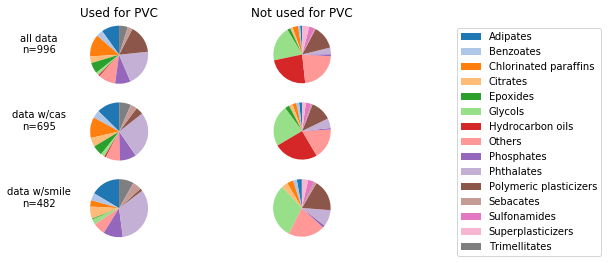

In [147]:
pvc_true_smcat = plast_data_cas[plast_data_cas['Has Smile'] == 1][plast_data_cas['Used for PVC'] == 1.0]['Chemical Category'].value_counts()
pvc_false_smcat = plast_data_cas[plast_data_cas['Has Smile'] == 1][plast_data_cas['Used for PVC'] == 0.0]['Chemical Category'].value_counts()

true_data_dict = {}
false_data_dict = {}
for cat in high_freq_cats:
    true_data_dict[cat] = 0
    false_data_dict[cat] = 0
    
for cat in pvc_true_smcat.index.to_list():
    if cat in high_freq_cats:
        true_data_dict[cat] += pvc_true_smcat[cat]
    else:
        true_data_dict['Others'] += pvc_true_smcat[cat]

for cat in pvc_false_smcat.index.to_list():
    if cat in high_freq_cats:
        false_data_dict[cat] += pvc_false_smcat[cat]
    else:
        false_data_dict['Others'] += pvc_false_smcat[cat]

true_sizes_sm = true_data_dict.values()
false_sizes_sm = false_data_dict.values()

colors = plt.cm.tab20((np.arange(20).astype(int)))
fig, axs = plt.subplots(3, 2)
axs[0,0].pie(true_sizes, startangle=90, colors=colors)
axs[0,0].axis('equal')
axs[0,0].set_title('Used for PVC')
axs[0,0].set_ylabel('all data\nn=996', rotation=0)
wedges, texts = axs[0,1].pie(false_sizes, startangle=90, colors=colors)
axs[0,1].axis('equal')
axs[0,1].legend(wedges, false_data_dict.keys(), loc='left', bbox_to_anchor=(2.0, 0, 0.5, 1))
axs[0,1].set_title('Not used for PVC')
axs[1,0].pie(true_sizes_cas, startangle=90, colors=colors)
axs[1,0].axis('equal')
axs[1,0].set_ylabel('data w/cas\nn=695', rotation=0)
axs[1,1].pie(false_sizes_cas, startangle=90, colors=colors)
axs[1,1].axis('equal')
axs[2,0].pie(true_sizes_sm, startangle=90, colors=colors)
axs[2,0].axis('equal')
axs[2,0].set_ylabel('data w/smile\nn=482', rotation=0)
axs[2,1].pie(false_sizes_sm, startangle=90, colors=colors)
axs[2,1].axis('equal')
fig.tight_layout()
plt.show()

In [145]:
len(plast_data_cas[plast_data_cas['Has Smile'] == 1]) - plast_data_cas[plast_data_cas['Has Smile'] == 1]['Used for PVC'].isna().sum() 

482

In [150]:
plast_data_cas[plast_data_cas.columns[:-2]].to_excel('data/cas_plasticizers.xls')